# Without Uniform/Equal class distribution


## T 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout
import tensorflow as tf
import keras

from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 3)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

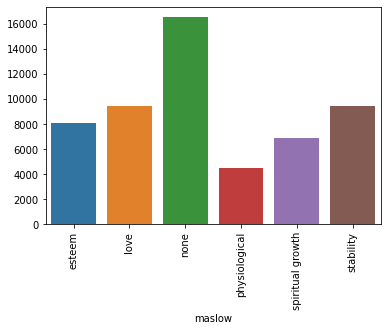

In [ ]:
import seaborn as sns 
c = df3.groupby('maslow')['maslow'].count()
sns.barplot(x = c.index, y = c.values)
plt.xticks(rotation = 90)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3

,sentence,maslow,reiss,maslowLabel
0,I began making fish curry for my boyfriend and I.,physiological,[food],3
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]",1
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]",3
2,I began making fish curry for my boyfriend and I.,physiological,[food],3
3,I began making fish curry for my boyfriend and I.,none,[none],2
...,...,...,...,...
47542,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47543,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47544,A crab was inside the shell pinching his leg.,none,[none],2
47545,A crab was inside the shell pinching his leg.,stability,[tranquility],5


In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['maslowLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=4487 (8.148%)
Class=1, n=9483 (17.221%)
Class=2, n=16547 (30.049%)
Class=4, n=6927 (12.579%)
Class=0, n=8134 (14.771%)
Class=5, n=9488 (17.230%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,i began making fish curry boyfriend i,physiological,[food],3
1,i began making fish curry boyfriend i,love,"[family, romance, food]",1
1,i began making fish curry boyfriend i,physiological,"[family, romance, food]",3
2,i began making fish curry boyfriend i,physiological,[food],3
3,i began making fish curry boyfriend i,none,[none],2
...,...,...,...,...
47542,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47543,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47544,a crab inside shell pinching leg,none,[none],2
47545,a crab inside shell pinching leg,stability,[tranquility],5


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

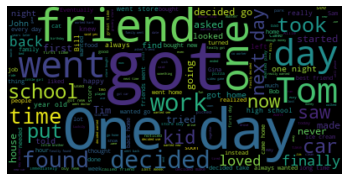

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 7254 samples and 295640 outcomes>
7254


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
21422,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


### Model LSTM

In [ ]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

In [ ]:
model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Dropout(0.2))
model.add(LSTM(200, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 62, 100)           725400    
                                                                 
 dropout_10 (Dropout)        (None, 62, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 200)               40200     
                                                                 
 dense_25 (Dense)            (None, 6)                 1206      
                                                                 
Total params: 1,007,606
Trainable params: 1,007,606
N

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= METRICS)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052, 62)
(11014, 62)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
model.fit(x_train, y_train,epochs=5,verbose=1,validation_split=0.1)

Epoch 1/5
1239/1239 [==============================] - 223s 177ms/step - loss: 1.6415 - tp: 789.0000 - fp: 668.0000 - tn: 197562.0000 - fn: 38857.0000 - categorical_cross_entropy: 1.6415 - precision: 0.5415 - recall: 0.0199 - auc: 0.6840 - prc: 0.3022 - val_loss: 1.5954 - val_tp: 221.0000 - val_fp: 209.0000 - val_tn: 21821.0000 - val_fn: 4185.0000 - val_categorical_cross_entropy: 1.5954 - val_precision: 0.5140 - val_recall: 0.0502 - val_auc: 0.7127 - val_prc: 0.3276
Epoch 2/5
1239/1239 [==============================] - 207s 167ms/step - loss: 1.4953 - tp: 4171.0000 - fp: 3114.0000 - tn: 195116.0000 - fn: 35475.0000 - categorical_cross_entropy: 1.4953 - precision: 0.5725 - recall: 0.1052 - auc: 0.7567 - prc: 0.3921 - val_loss: 1.5935 - val_tp: 364.0000 - val_fp: 390.0000 - val_tn: 21640.0000 - val_fn: 4042.0000 - val_categorical_cross_entropy: 1.5935 - val_precision: 0.4828 - val_recall: 0.0826 - val_auc: 0.7174 - val_prc: 0.3367
Epoch 3/5
1239/1239 [==============================] - 2

In [ ]:
model.evaluate(x_test, y_test)

169/169 [==============================] - 8s 49ms/step - loss: 3.1755 - tp: 310.0000 - fp: 1448.0000 - tn: 25477.0000 - fn: 5075.0000 - categorical_cross_entropy: 3.1755 - precision: 0.1763 - recall: 0.0576 - auc: 0.5088 - prc: 0.1706 - accuracy: 0.0000e+00


[3.1754701137542725,
 310.0,
 1448.0,
 25477.0,
 5075.0,
 3.1754701137542725,
 0.17633675038814545,
 0.05756731703877449,
 0.5087841153144836,
 0.17064206302165985,
 0.0]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([4.2563403e-01, 2.9093364e-05, 2.7402371e-01, 1.7323330e-03,
       8.5822061e-02, 2.1275878e-01], dtype=float32)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'categorical_cross_entropy', 'precision', 'recall', 'auc', 'prc', 'accuracy', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_categorical_cross_entropy', 'val_precision', 'val_recall', 'val_auc', 'val_prc', 'val_accuracy'])


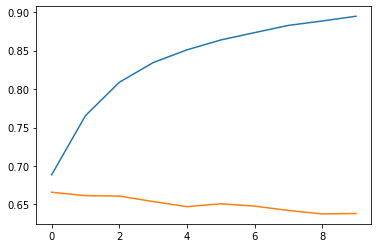

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(5385,)

In [ ]:
review_predictions

array([5, 2, 0, ..., 0, 3, 0])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0     956
1    1178
2     799
3     819
4     695
5     938
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[172 153 159 155 152 165]
 [190 202 186 216 197 187]
 [147 123 152 125 146 106]
 [121 149 112 149 127 161]
 [103 122 125 102 115 128]
 [165 148 163 151 161 150]]


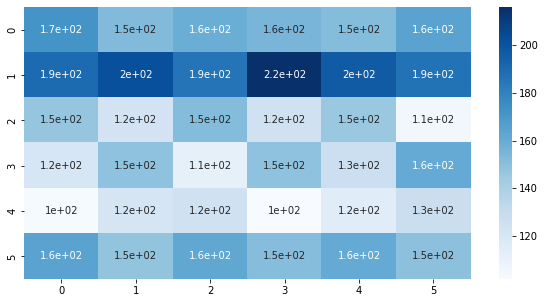

In [ ]:
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
#y_test_text

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
#integer_label[0:20]

In [ ]:
#text_label[0:20]

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesMaslow = list(df4['maslow'].unique())
uniqueClassesMaslowLabel = list(df4['maslowLabel'].unique())

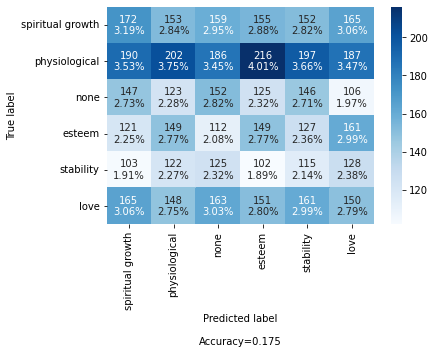

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
#x_test_text[0:5]

In [ ]:
print(uniqueClassesMaslow)
print(uniqueClassesMaslowLabel)

['spiritual growth', 'physiological', 'none', 'esteem', 'stability', 'love']
[4, 3, 2, 0, 5, 1]


In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 4 and integer_label[i] == 4 and count != 10:
        print(x_test_text[i])
        count = count + 1

she promised take time happy
ben determined become best writer possible
i respond
it turn family would come see instead
he passed interview offered job bank teller
an artist making anime show
mila working sewing project
but unfortunately would missing favorite show
her teacher submitted statewide contest
she trained hard long time


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(integer_label, review_predictions)

print('Labels::{}'.format(uniqueClassesMaslow))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Labels::['spiritual growth', 'physiological', 'none', 'esteem', 'stability', 'love']
precision: [0.17991632 0.17147708 0.1902378  0.18192918 0.16546763 0.15991471]
recall: [0.19153675 0.22519509 0.16945373 0.16592428 0.12806236 0.16722408]
fscore: [0.18554477 0.1946988  0.17924528 0.17355853 0.14438167 0.16348774]
support: [898 897 897 898 898 897]


In [ ]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(integer_label, review_predictions)
print(cohen_score)

0.009479872263702505


## T 2

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import sklearn

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout, Conv1D, MaxPooling1D, Dropout, Activation
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')


### Cleaning the Data

In [ ]:
df1 = df.drop(columns = ['action','motivation'])

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

AttributeError: ignored

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 8)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

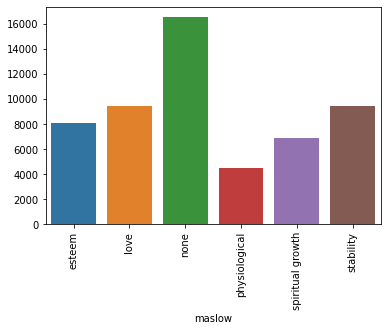

In [ ]:
c = df3.groupby('maslow')['maslow'].count()
sns.barplot(x = c.index, y = c.values)
plt.xticks(rotation = 90)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


In [ ]:
uniqueClassesMaslow = list(df3['maslow'].unique())
uniqueClassesMaslowLabel = list(df3['maslowLabel'].unique())
print(uniqueClassesMaslowLabel)
print(uniqueClassesMaslow)

[3, 1, 2, 4, 0, 5]
['physiological', 'love', 'none', 'spiritual growth', 'esteem', 'stability']


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def stemmer(string):
    words = nltk.word_tokenize(string)
    ps = PorterStemmer()
    s = []
    for each in words:
        s.append(ps.stem(each))
    return ' '.join(s)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    #return stemmer(lemmat(removestopwords(tokenization(string))))
    return stemmer(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))

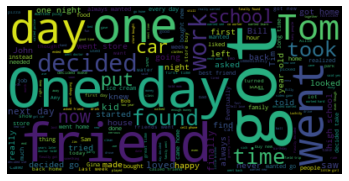

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
print(rslt)

<FreqDist with 5832 samples and 295640 outcomes>
5832
      Word  Frequency
0       he       6874
1        i       6037
2      she       5583
3      the       3627
4   friend       2513
5      day       2495
6      one       2408
7     went       2401
8       nt       2396
9     they       2361
10   decid       2333
11     got       2247
12    want       2011
13      go       1681
14     get       1498
15     new       1438
16   would       1376
17    work       1353
18    play       1308
19    home       1253
20    time       1245
21    when       1238
22    told       1218
23   could       1192
24     tri       1180
25     dog       1111
26    call       1087
27    took       1082
28     ask       1075
29      my       1065


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

57


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss,maslowLabel
28387,13ec7161-69f7-499a-8060-4ea87fc8f8ed,4,Villanova,none,The field for the final four has been establis...,in stunner 10th seed syracus upset number 1 se...,none,[none],2


### Model BERT

https://www.section.io/engineering-education/classification-model-using-bert-and-tensorflow/

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 8.4 MB/s 
     |████████████████████████████████| 1.8 MB 8.7 MB/s 
     |████████████████████████████████| 237 kB 67.2 MB/s 
     |████████████████████████████████| 352 kB 71.8 MB/s 
     |████████████████████████████████| 92 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 
     |████████████████████████████████| 1.1 MB 69.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 48.3 MB 1.4 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 1.2 MB 47.2 MB/s 


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
'''
model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Dropout(0.2))
model.add(LSTM(200, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))
'''
#model.summary()

"\nmodel = Sequential()\nmodel.add(Embedding(7254, 100, input_length=62))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(200, activation = 'tanh'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units = 200, activation = 'relu'))\nmodel.add(Dense(6, activation='softmax'))\n"

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
model.fit(x_train, y_train,epochs=5,verbose=1,validation_split= 0.1)

Epoch 1/5
1239/1239 [==============================] - 463s 373ms/step - loss: 1.6885 - accuracy: 0.2985 - val_loss: 1.6641 - val_accuracy: 0.3055
Epoch 2/5
1239/1239 [==============================] - 461s 372ms/step - loss: 1.6833 - accuracy: 0.3022 - val_loss: 1.6796 - val_accuracy: 0.2907
Epoch 3/5
1239/1239 [==============================] - 461s 372ms/step - loss: 1.6784 - accuracy: 0.3057 - val_loss: 1.7030 - val_accuracy: 0.2744
Epoch 4/5
1239/1239 [==============================] - 460s 371ms/step - loss: 1.6765 - accuracy: 0.3053 - val_loss: 1.6795 - val_accuracy: 0.3198
Epoch 5/5
1239/1239 [==============================] - 459s 371ms/step - loss: 1.6716 - accuracy: 0.3073 - val_loss: 1.6774 - val_accuracy: 0.3134


In [ ]:
model.evaluate(x_test, y_test)

345/345 [==============================] - 115s 333ms/step - loss: 1.6868 - accuracy: 0.3034


[1.6868268251419067, 0.30343198776245117]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([0.1419845 , 0.19710651, 0.29690412, 0.05900456, 0.15983005,
       0.14517029], dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(11014,)

In [ ]:
review_predictions

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0     119
1      61
2    9684
3      94
4       1
5    1055
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[  36   14   25    3   23   18]
 [   9   30    9    2    5    6]
 [1422 1709 2967  756 1242 1588]
 [   6   14   19   37    4   14]
 [   0    0    1    0    0    0]
 [ 154  130  289   99  111  272]]


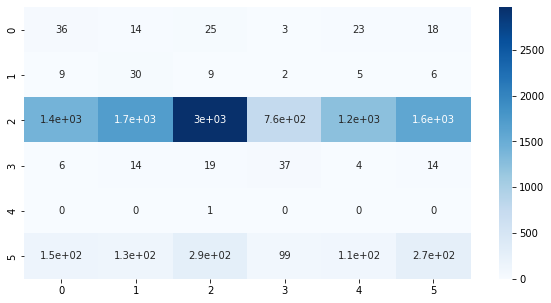

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
y_test_text

12966    4
38839    1
10485    1
30649    3
3592     2
        ..
34501    5
18501    2
23482    2
5892     0
264      5
Name: maslowLabel, Length: 11014, dtype: int64

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
integer_label[0:20]

0     4
1     1
2     1
3     3
4     2
5     1
6     5
7     5
8     0
9     2
10    3
11    2
12    4
13    0
14    5
15    2
16    0
17    1
18    3
19    1
Name: maslowLabel, dtype: int64

In [ ]:
text_label[0:20]

0     spiritual growth
1                 love
2                 love
3        physiological
4                 none
5                 love
6            stability
7            stability
8               esteem
9                 none
10       physiological
11                none
12    spiritual growth
13              esteem
14           stability
15                none
16              esteem
17                love
18       physiological
19                love
dtype: object

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

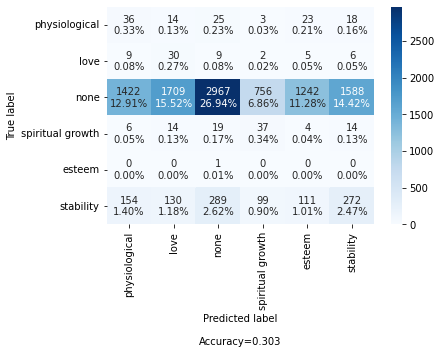

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
x_test_text[0:5]

0                      the bow pick shoot father
1        the note ask jim like ami ask answer ye
2    we becam close friend made time much easier
3                     she pick cutest littl doll
4    the insur specialist assur would better car
Name: sentence, dtype: object

In [ ]:
print(uniqueClassesMaslowLabel)
print(uniqueClassesMaslow)

[3, 1, 2, 4, 0, 5]
['physiological', 'love', 'none', 'spiritual growth', 'esteem', 'stability']


In [ ]:
y_test

array([[0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

two boy knock book arm hallway
we becam close friend made time much easier
hi instructor shook head disappointingli
everi month mail gift
he famou antic attract new custom
he made varsiti squad
her scienc teacher encourag compet scienc fair
the band contact two month wed
within week everyon knew
my wife daughter went shop queen


In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 1 and integer_label[i] == 1 and count != 10:
        print(x_test_text[i])
        count = count + 1

the note ask jim like ami ask answer ye
we becam close friend made time much easier
no one town could believ phil left wife laurel
jane apolog slow
howev dan girlfriend move need larger bed
teddi got elect becom presid
andrea shock delight tell husband news
one kid dad said look like antiqu
bob mike want go lake fish trip
we decid go rock climb


## Error pg268 NLP in action

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import sklearn

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout, Conv1D, MaxPooling1D, Dropout, Activation
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
from nltk.tokenize import TreebankWordTokenizer 
from gensim.models import KeyedVectors
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100") 

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df1 = df.drop(columns = ['action','motivation'])

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df2 = df1
df3 = df2.explode('maslow')
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3.head(1)

,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss,maslowLabel
0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann0,NaN,I began making fish curry for my boyfriend and I.,physiological,[food],3


In [ ]:
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])
            except KeyError:
                pass 
        vectorized_data.append(sample_vecs)
    return vectorized_data

In [ ]:
d = df['sentence'].tolist()

In [ ]:
vectorized_data = tokenize_and_vectorize(d)

In [ ]:
len(d)

47547

In [ ]:
expected = df3['maslow']
len(vectorized_data)

47547

In [ ]:
vectorized_data[47530]

[array([-0.27086  ,  0.044006 , -0.02026  , -0.17395  ,  0.6444   ,
         0.71213  ,  0.3551   ,  0.47138  , -0.29637  ,  0.54427  ,
        -0.72294  , -0.0047612,  0.040611 ,  0.043236 ,  0.29729  ,
         0.10725  ,  0.40156  , -0.53662  ,  0.033382 ,  0.067396 ,
         0.64556  , -0.085523 ,  0.14103  ,  0.094539 ,  0.74947  ,
        -0.194    , -0.68739  , -0.41741  , -0.22807  ,  0.12     ,
        -0.48999  ,  0.80945  ,  0.045138 , -0.11898  ,  0.20161  ,
         0.39276  , -0.20121  ,  0.31354  ,  0.75304  ,  0.25907  ,
        -0.11566  , -0.029319 ,  0.93499  , -0.36067  ,  0.5242   ,
         0.23706  ,  0.52715  ,  0.22869  , -0.51958  , -0.79349  ,
        -0.20368  , -0.50187  ,  0.18748  ,  0.94282  , -0.44834  ,
        -3.6792   ,  0.044183 , -0.26751  ,  2.1997   ,  0.241    ,
        -0.033425 ,  0.69553  , -0.64472  , -0.0072277,  0.89575  ,
         0.20015  ,  0.46493  ,  0.61933  , -0.1066   ,  0.08691  ,
        -0.4623   ,  0.18262  , -0.15849  ,  0.0

In [ ]:
split_point = int(len(vectorized_data)*0.8)
print(split_point)

38037


In [ ]:
x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]
maxlen = 8 
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

def pad_trunc(data, maxlen):
    new_data = []
    zero_vector = []
    for i in range(len(data)):
        zero_vector.append(0)
    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample 
        new_data.append(temp)
    return new_data

In [ ]:
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

In [ ]:
len(x_train)

38037

In [ ]:
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: ignored

## T 4

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout
import tensorflow as tf
import keras

from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 3)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

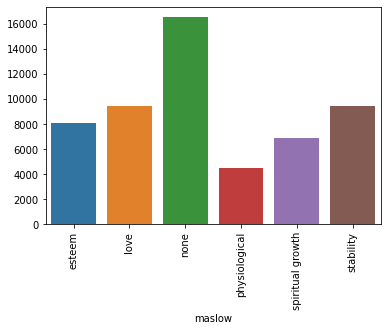

In [ ]:
import seaborn as sns 
c = df3.groupby('maslow')['maslow'].count()
sns.barplot(x = c.index, y = c.values)
plt.xticks(rotation = 90)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3

,sentence,maslow,reiss,maslowLabel
0,I began making fish curry for my boyfriend and I.,physiological,[food],3
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]",1
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]",3
2,I began making fish curry for my boyfriend and I.,physiological,[food],3
3,I began making fish curry for my boyfriend and I.,none,[none],2
...,...,...,...,...
47542,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47543,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47544,A crab was inside the shell pinching his leg.,none,[none],2
47545,A crab was inside the shell pinching his leg.,stability,[tranquility],5


In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['maslowLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=4487 (8.148%)
Class=1, n=9483 (17.221%)
Class=2, n=16547 (30.049%)
Class=4, n=6927 (12.579%)
Class=0, n=8134 (14.771%)
Class=5, n=9488 (17.230%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,i began making fish curry boyfriend i,physiological,[food],3
1,i began making fish curry boyfriend i,love,"[family, romance, food]",1
1,i began making fish curry boyfriend i,physiological,"[family, romance, food]",3
2,i began making fish curry boyfriend i,physiological,[food],3
3,i began making fish curry boyfriend i,none,[none],2
...,...,...,...,...
47542,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47543,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47544,a crab inside shell pinching leg,none,[none],2
47545,a crab inside shell pinching leg,stability,[tranquility],5


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

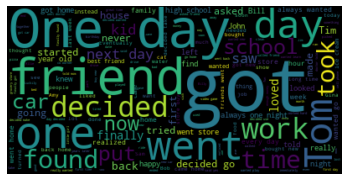

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 7254 samples and 295640 outcomes>
7254


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
21422,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


### Model FFN with CNN

In [ ]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers import GlobalMaxPooling1D

In [ ]:
#input_array = np.random.randint(1000, size=(32, 10))
#print(input_array.ndim)
#print(input_array.shape)
#print(input_array.size)
#k = input_array.flatten()
#print(len(k))
#print(input_array)

In [ ]:
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 62, 100)           725400    
                                                                 
 conv1d (Conv1D)             (None, 60, 250)           75250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 activation (Activation)     (None, 250)               0         
                                                        

In [ ]:
'''
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
'''

"\nMETRICS = [\n      keras.metrics.TruePositives(name='tp'),\n      keras.metrics.FalsePositives(name='fp'),\n      keras.metrics.TrueNegatives(name='tn'),\n      keras.metrics.FalseNegatives(name='fn'), \n      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),\n      keras.metrics.Precision(name='precision'),\n      keras.metrics.Recall(name='recall'),\n      keras.metrics.AUC(name='auc'),\n      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve\n]\n"

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= 'accuracy')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
print(x_train.ndim)
print(x_train.shape)
print(x_test.shape)

2
(44052, 62)
(11014, 62)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
model.fit(x_train, y_train,verbose=1, validation_data = (x_test, y_test), batch_size = 32, epochs = epochs)

Epoch 1/10
1377/1377 [==============================] - 57s 40ms/step - loss: 1.6314 - accuracy: 0.3348 - val_loss: 1.7998 - val_accuracy: 0.2584
Epoch 2/10
1377/1377 [==============================] - 64s 47ms/step - loss: 1.4744 - accuracy: 0.4066 - val_loss: 1.8779 - val_accuracy: 0.2330
Epoch 3/10
1377/1377 [==============================] - 55s 40ms/step - loss: 1.3705 - accuracy: 0.4376 - val_loss: 1.8776 - val_accuracy: 0.2261
Epoch 4/10
1377/1377 [==============================] - 50s 37ms/step - loss: 1.2897 - accuracy: 0.4540 - val_loss: 1.9926 - val_accuracy: 0.2272
Epoch 5/10
1377/1377 [==============================] - 53s 39ms/step - loss: 1.2199 - accuracy: 0.4635 - val_loss: 2.1604 - val_accuracy: 0.2400
Epoch 6/10
1377/1377 [==============================] - 49s 35ms/step - loss: 1.1627 - accuracy: 0.4685 - val_loss: 2.2345 - val_accuracy: 0.2468
Epoch 7/10
1377/1377 [==============================] - 51s 37ms/step - loss: 1.1166 - accuracy: 0.4737 - val_loss: 2.3498 -

In [ ]:
model.evaluate(x_test, y_test)

345/345 [==============================] - 3s 9ms/step - loss: 2.6645 - accuracy: 0.2214


[2.6644864082336426, 0.2213546335697174]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([0.03046741, 0.5054372 , 0.23377813, 0.12541716, 0.01784164,
       0.08705846], dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(11014,)

In [ ]:
review_predictions

array([0, 2, 1, ..., 2, 0, 5])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    1521
1    2360
2    4147
3     931
4     600
5    1455
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[ 214  303  452  104  205  243]
 [ 334  408  702  200  299  417]
 [ 591  722 1242  387  502  703]
 [ 154  130  269   66  132  180]
 [ 106   99  185   48   67   95]
 [ 228  235  460   92  180  260]]


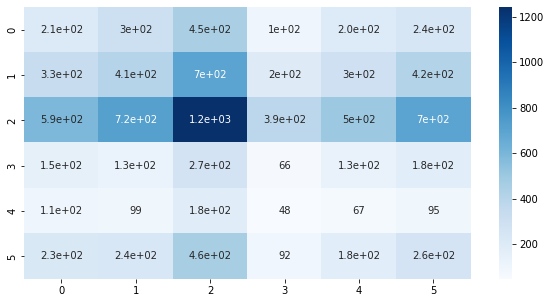

In [ ]:
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
#y_test_text

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
#integer_label[0:20]

In [ ]:
#text_label[0:20]

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesMaslow = list(df4['maslow'].unique())
uniqueClassesMaslowLabel = list(df4['maslowLabel'].unique())

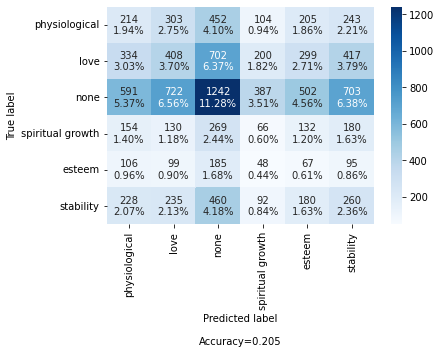

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
#x_test_text[0:5]

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

two boy knocked book arm hallway
we became close friend made time much easier
his instructor shook head disappointingly
every month mailed gift
he famous antic attracted new customer
he made varsity squad
her science teacher encouraged compete science fair
the band contacted two month wedding
within week everyone knew
my wife daughter went shopping queen


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(integer_label, review_predictions)

print('Labels::{}'.format(uniqueClassesMaslow))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Labels::['physiological', 'love', 'none', 'spiritual growth', 'esteem', 'stability']
precision: [0.14069691 0.17288136 0.29949361 0.07089151 0.11166667 0.17869416]
recall: [0.13153042 0.21507644 0.37522659 0.0735786  0.04837545 0.1369863 ]
fscore: [0.13595934 0.19168428 0.33310983 0.07221007 0.0675063  0.155085  ]
support: [1627 1897 3310  897 1385 1898]


In [ ]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(integer_label, review_predictions)
print(cohen_score)

-0.0025701661192405467


## Error Roberta T5

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,i began making fish curry boyfriend i,physiological,[food],3
1,i began making fish curry boyfriend i,love,"[family, romance, food]",1
1,i began making fish curry boyfriend i,physiological,"[family, romance, food]",3
2,i began making fish curry boyfriend i,physiological,[food],3
3,i began making fish curry boyfriend i,none,[none],2
...,...,...,...,...
47542,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47543,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47544,a crab inside shell pinching leg,none,[none],2
47545,a crab inside shell pinching leg,stability,[tranquility],5


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

62


,sentence,maslow,reiss,maslowLabel
21422,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


In [ ]:
x_train = df4['sentence']

In [ ]:
!pip install transformers
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 
     |████████████████████████████████| 101 kB 10.0 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
x_train[3]

'i began making fish curry boyfriend i'

In [ ]:
# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']
output_list = []
lis_sentence = df4['sentence'].to_list()
for i in range(len(lis_sentence)):
    encoded_tweet = tokenizer(lis_sentence[i], return_tensors='pt')
    output = model(**encoded_tweet)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    output_list.append(labels[np.argmax(scores)])


KeyboardInterrupt: ignored

In [ ]:
print(x_train.shape[0])
print(len(output_list))

55066

## T5

In [ ]:
! pip install nlpia

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import os 

from random import shuffle
from nlpia.loaders import get_data 
from nltk.tokenize import TreebankWordTokenizer 
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter 
from nltk.corpus import stopwords 
import re
from string import punctuation
import nltk

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/usr/local/lib/python3.7/dist-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/nlpia

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 3)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4.head(1)

,sentence,maslow,reiss,maslowLabel
0,i began making fish curry boyfriend i,physiological,[food],3


In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 7254 samples and 295640 outcomes>
7254


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
21422,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


In [ ]:
# Number of unique words in df4['sentence']
results = set()
len(df4['sentence'].str.lower().str.split().apply(results.update))

55066

### RNN + LSTM for Classifying Positive or negative reviews

In [ ]:
import numpy as np 
#from tensorflow.keras.preprocessing import sequence  Use this: tf.keras.utils.timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Embedding, LSTM 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb 
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
max_features = 20000
maxlen = 62 # cuts text after this number of words
batch_size = 32

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
tokenizer = Tokenizer(num_words = 55066, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 55066, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 909, 550,  19, 205], dtype=int32)

In [ ]:
x_train[0]
len(x_train[0])  # This sentence is or 218 words

62

In [ ]:
y_train[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
print(len(x_train),'train_sequences')

44052 train_sequences


tf.keras.utils.pad_sequences: This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)
print(x_train.shape, x_test.shape)

(44052, 62) (11014, 62)


In [ ]:
x_train[0]
len(x_train[0])   # Now this sentence is truncated to 80 words which frequently occur in the sentence

62

In [ ]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 909, 550,  19, 205], dtype=int32)

we create a mapping 
from each word to a unique integer, and we present this integer as input to an 
Embedding layer, which converts the integer to an embedding.

Model setup

In [ ]:
model = Sequential()
model.add(Embedding( input_dim = max_features, output_dim = 64))   # Why is output_dim = 128  
model.add(Dense(units = 128))
model.add(LSTM( units = 128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(units = 6, activation = 'softmax'))   # Can we merge Activation and Dense 
model.summary()
# input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim: Integer. Dimension of the dense embedding.
# dropout_U (changed to recurrent_dropout): float between 0 and 1. Fraction of the input units to drop for recurrent connections.
# dropout_W (changes to dropout): float between 0 and 1. Fraction of the input units to drop for input gates.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 dense_2 (Dense)             (None, None, 128)         8320      
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,420,678
Trainable params: 1,420,678
Non-trainable params: 0
_________________________________________________________________


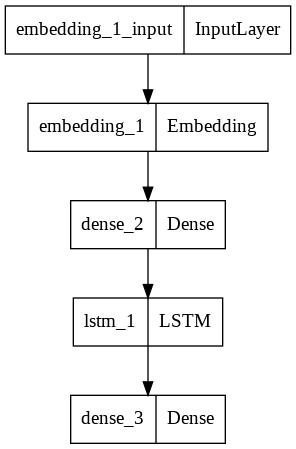

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.fit(x_train,y_train,batch_size = batch_size,epochs = 5, verbose = 1, validation_data = (x_test, y_test))

In [ ]:
earlystopping = EarlyStopping(monitor ="val_loss",mode ="min", patience = 5, restore_best_weights = True)
  
history = model.fit(x_train, y_train, batch_size = 32,
                    epochs = 5, verbose = 1,validation_data = (x_test, y_test), 
                    callbacks =[earlystopping])

Epoch 1/5
1377/1377 [==============================] - 380s 269ms/step - loss: 1.6238 - accuracy: 0.3346 - val_loss: 1.8054 - val_accuracy: 0.2548
Epoch 2/5
1377/1377 [==============================] - 326s 236ms/step - loss: 1.4800 - accuracy: 0.4028 - val_loss: 1.8603 - val_accuracy: 0.2284
Epoch 3/5
1377/1377 [==============================] - 322s 234ms/step - loss: 1.4056 - accuracy: 0.4266 - val_loss: 1.9579 - val_accuracy: 0.2244
Epoch 4/5
1377/1377 [==============================] - 321s 233ms/step - loss: 1.3542 - accuracy: 0.4418 - val_loss: 1.9942 - val_accuracy: 0.2112
Epoch 5/5
1377/1377 [==============================] - 324s 236ms/step - loss: 1.3111 - accuracy: 0.4513 - val_loss: 2.0808 - val_accuracy: 0.2234


In [ ]:
x_test.shape

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['accuracy'],label = 'accuracy' )
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [ ]:
plt.plot(history.history['loss'])

The model overfits

In [ ]:
train_score, train_acc = model.evaluate(x_train, y_train, batch_size = 32)
test_score, test_acc = model.evaluate(x_test, y_test, batch_size = 32)
print('Train score', train_score)
print('Test score', test_score)
print('Train accuracy', train_acc)
print('Train accuarcy', test_acc)


# With Uniform Classes

## T 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout
import tensorflow as tf
import keras

from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


In [ ]:
df3 = df3.drop_duplicates(subset = ['sentence']).reset_index(drop = True)

### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(12409, 3)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,1415
love,1298
none,5638
physiological,866
spiritual growth,1527
stability,1665


In [ ]:
df3.head(1)

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]


In [ ]:
undersampling_count = df3[['sentence','maslow']].groupby('maslow').count().min()[0]
print(undersampling_count)   # Therefore we dont sample Phsycological as it has the minimum number of sample i.e dataframe[0]
lis = list(df3['maslow'].unique())
print(lis)

866
['none', 'physiological', 'esteem', 'love', 'stability', 'spiritual growth']


In [ ]:
dontSeeIndex = 1

In [ ]:
from sklearn.utils import shuffle
lis = list(df3['maslow'].unique())
print(type(lis))
print(lis)
dataframes = []
for i in range(len(lis)):
    dataframe = 't' + str(i)
    dataframe = df3[df3['maslow'] == lis[i]]
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop(columns = 'index')
    if i!=dontSeeIndex:
        dataframe = shuffle(dataframe)
        dataframe = dataframe.iloc[:866][:]
    dataframes.append(dataframe)
dataframes[0].head(1)
dataframes[5].head(1)

<class 'list'>
['none', 'physiological', 'esteem', 'love', 'stability', 'spiritual growth']


,sentence,maslow,reiss,maslowLabel
266,She decided to sell it and buy an Apple Watch ...,spiritual growth,[curiosity],4


In [ ]:
df3 = pd.concat(dataframes)
df3 = shuffle(df3)
df3 = df3.reset_index()
df3 = df3.drop(columns = 'index')
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,866
love,866
none,866
physiological,866
spiritual growth,866
stability,866


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3

,sentence,maslow,reiss,maslowLabel
0,Her teacher promoted her to the next class up.,love,[contact],1
1,Gabriel was attracted to the woman on the drums.,esteem,"[approval, contact]",0
2,Marianne woke up and felt numb one one side of...,none,[none],2
3,Zach walked into the store.,physiological,[food],3
4,She soon became his girlfriend.,love,"[contact, romance]",1
...,...,...,...,...
5191,Gina watched alone as the girls giggled and go...,love,[none],1
5192,The next morning it worked fine.,none,[none],2
5193,Marla needed chips for her football party.,love,"[contact, food]",1
5194,An artist was making an anime show.,none,[none],2


In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['love' 'esteem' 'none' 'physiological' 'spiritual growth' 'stability']
[1 0 2 3 4 5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['maslowLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=866 (16.667%)
Class=0, n=866 (16.667%)
Class=2, n=866 (16.667%)
Class=3, n=866 (16.667%)
Class=4, n=866 (16.667%)
Class=5, n=866 (16.667%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,her teacher promoted next class,love,[contact],1
1,gabriel attracted woman drum,esteem,"[approval, contact]",0
2,marianne woke felt numb one one side body,none,[none],2
3,zach walked store,physiological,[food],3
4,she soon became girlfriend,love,"[contact, romance]",1
...,...,...,...,...
5191,gina watched alone girl giggled gossiped,love,[none],1
5192,the next morning worked fine,none,[none],2
5193,marla needed chip football party,love,"[contact, food]",1
5194,an artist making anime show,none,[none],2


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

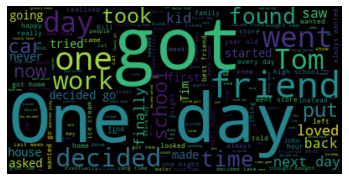

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 4900 samples and 27618 outcomes>
4900


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
2166,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


### Model LSTM

In [ ]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

In [ ]:
model = Sequential()
model.add(Embedding(4900, 50, input_length=62))
model.add(Dropout(0.2))
model.add(LSTM(100, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 62, 50)            245000    
                                                                 
 dropout_2 (Dropout)         (None, 62, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               20200     
                                                                 
 dense_3 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 326,806
Trainable params: 326,806
Non-tr

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.Accuracy(name = 'accuracy')
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= 'accuracy')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(4156,)
(1040,)


In [ ]:
tokenizer = Tokenizer(num_words = 4900, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 4900, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
print(x_train.shape)
print(x_test.shape)

(4156, 62)
(1040, 62)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
history = model.fit(x_train, y_train,epochs=10,verbose=1,validation_data = (x_test,y_test))

Epoch 1/10
130/130 [==============================] - 5s 17ms/step - loss: 1.7916 - accuracy: 0.1708 - val_loss: 1.7924 - val_accuracy: 0.1663
Epoch 2/10
130/130 [==============================] - 2s 12ms/step - loss: 1.6605 - accuracy: 0.3308 - val_loss: 1.9661 - val_accuracy: 0.1779
Epoch 3/10
130/130 [==============================] - 1s 11ms/step - loss: 1.2270 - accuracy: 0.5493 - val_loss: 2.3508 - val_accuracy: 0.1692
Epoch 4/10
130/130 [==============================] - 1s 11ms/step - loss: 0.8157 - accuracy: 0.7154 - val_loss: 2.9000 - val_accuracy: 0.1567
Epoch 5/10
130/130 [==============================] - 1s 11ms/step - loss: 0.5367 - accuracy: 0.8193 - val_loss: 3.3898 - val_accuracy: 0.1663
Epoch 6/10
130/130 [==============================] - 1s 11ms/step - loss: 0.3892 - accuracy: 0.8734 - val_loss: 3.9959 - val_accuracy: 0.1731
Epoch 7/10
130/130 [==============================] - 1s 11ms/step - loss: 0.3033 - accuracy: 0.9021 - val_loss: 4.5296 - val_accuracy: 0.1683

In [ ]:
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 6ms/step - loss: 6.0942 - accuracy: 0.1606


[6.094207763671875, 0.1605769246816635]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([0.07375965, 0.27284178, 0.01357113, 0.58048695, 0.04166781,
       0.01767265], dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(1040,)

In [ ]:
review_predictions

array([2, 1, 3, ..., 1, 1, 2])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    205
1    148
2    131
3    174
4    176
5    206
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[31 35 38 33 24 44]
 [27 24 26 27 20 24]
 [19 27 22 15 24 24]
 [35 20 23 34 33 29]
 [27 32 33 28 30 26]
 [35 35 31 36 43 26]]


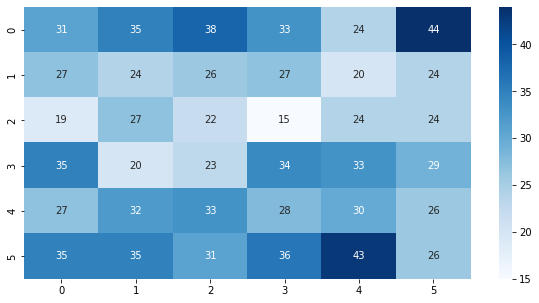

In [ ]:
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
#y_test_text

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
#integer_label[0:20]

In [ ]:
#text_label[0:20]

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesMaslow = list(df4['maslow'].unique())
uniqueClassesMaslowLabel = list(df4['maslowLabel'].unique())

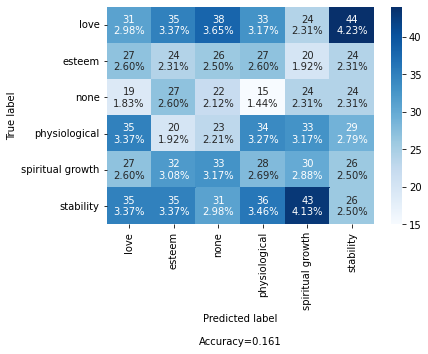

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
#x_test_text[0:5]

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

they talked long time
jenny always wanted wear pair high heel
in middle school anna started playing soccer lunch time
when went outside shirtless one laughed anymore
finally brother gave back
he set practiced swing
he nt graceful dancer fun
he better position
but continually worried would nt taste good enough
lebron needed new laptop school


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(integer_label, review_predictions)

print('Labels::{}'.format(uniqueClassesMaslow))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Labels::['love', 'esteem', 'none', 'physiological', 'spiritual growth', 'stability']
precision: [0.15121951 0.16216216 0.16793893 0.1954023  0.17045455 0.12621359]
recall: [0.17816092 0.13872832 0.12716763 0.19653179 0.17241379 0.15028902]
fscore: [0.16358839 0.14953271 0.14473684 0.19596542 0.17142857 0.13720317]
support: [174 173 173 173 174 173]


In [ ]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(integer_label, review_predictions)
print(cohen_score)

-0.007346063847846418


## T 2

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import sklearn

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout, Conv1D, MaxPooling1D, Dropout, Activation
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df1 = df.drop(columns = ['action','motivation'])

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss
0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann0,NaN,I began making fish curry for my boyfriend and I.,physiological,[food]
1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann1,NaN,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann1,NaN,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann2,NaN,I began making fish curry for my boyfriend and I.,physiological,[food]
3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,Boyfriend,none,NaN,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 8)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

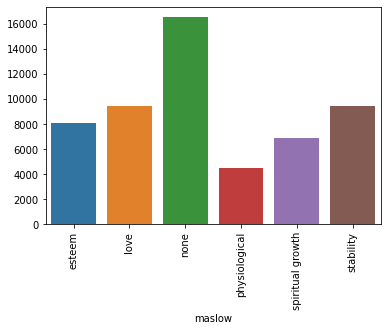

In [ ]:
c = df3.groupby('maslow')['maslow'].count()
sns.barplot(x = c.index, y = c.values)
plt.xticks(rotation = 90)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
# UNDERSAMPLING
undersampling_count = df3[['sentence','maslow']].groupby('maslow').count().min()[0]
dontSeeIndex = 0

from sklearn.utils import shuffle
lis = list(df3['maslow'].unique())
print(type(lis))
print(lis)
dataframes = []
for i in range(len(lis)):
    dataframe = 't' + str(i)
    dataframe = df3[df3['maslow'] == lis[i]]
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop(columns = 'index')
    if i!=dontSeeIndex:
        dataframe = shuffle(dataframe)
        dataframe = dataframe.iloc[:4487][:]
    dataframes.append(dataframe)
dataframes[0].head(1)
dataframes[5].head(1)

<class 'list'>
['physiological', 'love', 'none', 'spiritual growth', 'esteem', 'stability']


,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss
6740,66d24bf8-2666-4a13-90cd-15b93c3e60d3,1,Kay,ann0,NaN,Kay was at work when a headache started.,stability,[health]


In [ ]:
df3 = pd.concat(dataframes)
df3 = shuffle(df3)
df3 = df3.reset_index()
df3 = df3.drop(columns = 'index')
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,4487
love,4487
none,4487
physiological,4487
spiritual growth,4487
stability,4487


In [ ]:
k1 = df3[df3['maslow'] == 'none'] 
k2 = df3[df3['maslow'] == 'physiological']
df3 = pd.concat([k1,k2],axis = 0)
df3 = shuffle(df3)
df3 = df3.reset_index()
df3 = df3.drop(columns = 'index')

In [ ]:
df3.tail()

,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss,maslowLabel
8969,efd5baba-71a7-46a7-974f-33043029f548,2,Charity,none,Rita decided she wanted to raise money for her...,She first tried to get people to donate money.,none,[none],0
8970,e9adcf0a-dccd-4f77-b476-f5d76bf7c453,5,Detective,ann1,In the first police interrogation Ike was very...,Ike decided to stop talking and wait until he ...,none,[none],0
8971,9db1c645-4a9f-4e45-817e-6d08434982b6,3,Cliff,ann0,Cliff still lived with his parents.|He had bee...,Cliff would stay out until three in the morning.,physiological,[none],1
8972,36f0e5cf-0066-40c2-bdfd-540691f0d018,1,The murderer,none,NaN,A detective received a call about an unsolved ...,none,[none],0
8973,74fb272f-034c-4846-89ce-0e2f6884c32e,5,I (myself),ann1,My wife and I went out to dinner on Valentine'...,"We still gave a good tip, as the waitress was ...",physiological,"[contact, food]",1


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['none' 'physiological']
[0 1]


In [ ]:
uniqueClassesMaslow = list(df3['maslow'].unique())
uniqueClassesMaslowLabel = list(df3['maslowLabel'].unique())
print(uniqueClassesMaslowLabel)
print(uniqueClassesMaslow)

[0, 1]
['none', 'physiological']


In [ ]:
df4 = df3.copy()

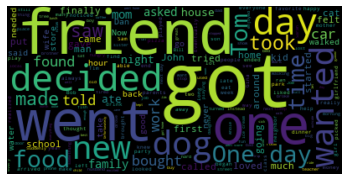

In [ ]:
common_words = ''
for i in df4.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
print(rslt)

<FreqDist with 5749 samples and 90221 outcomes>
5749
    Word  Frequency
0      .       8657
1    the       4078
2     to       3131
3      a       2660
4    was       2126
5     he       1951
6    and       1721
7    she       1720
8    her       1323
9      ,       1315
10   his       1109
11    it       1064
12     i        961
13    in        927
14    of        856
15   for        792
16   had        745
17    on        709
18  they        635
19    at        508
20    up        487
21   out        464
22    's        447
23    my        446
24  that        420
25  when        408
26  went        403
27  with        399
28   got        397
29   day        392


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

72


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,storyid,linenum,char,motiveworkerid,context,sentence,maslow,reiss,maslowLabel
796,d1c1e785-5fd0-4d0a-ad88-79a2e5eaafc1,5,Monitor,none,I walked into detention with an attitude.|The ...,"Just then, Bethany walked in and told him it w...",none,[none],0


### Model BERT

https://www.section.io/engineering-education/classification-model-using-bert-and-tensorflow/

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 17.5 MB/s 
     |████████████████████████████████| 1.8 MB 18.2 MB/s 
     |████████████████████████████████| 238 kB 48.0 MB/s 
     |████████████████████████████████| 48.3 MB 138 kB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 92 kB 8.1 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 1.2 MB 32.8 MB/s 
     |████████████████████████████████| 99 kB 5.2 MB/s 
     |████████████████████████████████| 352 kB 70.2 MB/s 


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(2, activation='softmax', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.Accuracy(name = 'accuracy')
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(7179,)
(1795,)


In [ ]:
print(x_train.shape)
print(x_test.shape)

(7179,)
(1795,)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
model.fit(x_train, y_train,epochs=10,verbose=1,validation_split= 0.1)   

Epoch 1/10
  2/202 [..............................] - ETA: 58:58 - loss: 0.6840 - tp: 37.0000 - fp: 27.0000 - tn: 37.0000 - fn: 27.0000 - categorical_cross_entropy: 0.6840 - precision: 0.5781 - recall: 0.5781 - auc: 0.6211 - prc: 0.5980 - accuracy: 0.0000e+00  

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(x_test, y_test)

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([0.10600586, 0.17121187, 0.15059093, 0.1605388 , 0.17641205,
       0.23524052], dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(5385,)

In [ ]:
review_predictions

array([1, 5, 5, ..., 1, 0, 3])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0     187
1    1878
2     274
3    1189
4     424
5    1433
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[ 77  20  35   9  27  19]
 [315 530 301 190 318 224]
 [ 45  27  89  32  33  48]
 [ 98 131 155 435 182 188]
 [ 98  35  73  40 127  51]
 [265 154 244 192 211 367]]


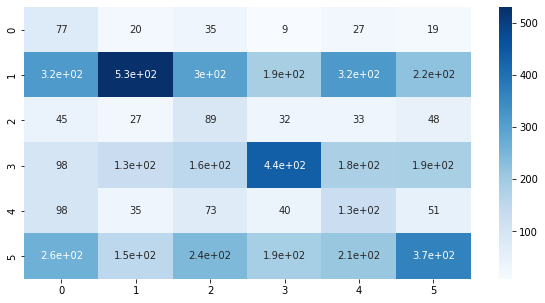

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
y_test_text

9490     1
23768    5
6019     2
12073    2
1926     3
        ..
20959    2
9324     1
25035    1
14299    0
26542    2
Name: maslowLabel, Length: 5385, dtype: int64

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
integer_label[0:20]

0     1
1     5
2     2
3     2
4     3
5     5
6     1
7     1
8     5
9     4
10    0
11    3
12    0
13    3
14    2
15    4
16    2
17    5
18    5
19    0
Name: maslowLabel, dtype: int64

In [ ]:
text_label[0:20]

0                 love
1            stability
2                 none
3                 none
4        physiological
5            stability
6                 love
7                 love
8            stability
9     spiritual growth
10              esteem
11       physiological
12              esteem
13       physiological
14                none
15    spiritual growth
16                none
17           stability
18           stability
19              esteem
dtype: object

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
print(uniqueClassesMaslowLabel)
print(uniqueClassesMaslow)

[4, 1, 5, 0, 3, 2]
['spiritual growth', 'love', 'stability', 'esteem', 'physiological', 'none']


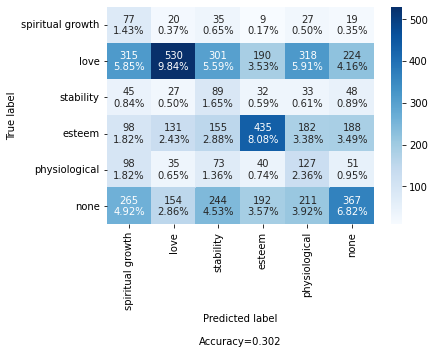

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
x_test_text[0:5]

0                 they married share physical intimacy
1                       soon robber ran joe got shaken
2                                       i decided give
3             she covered returned cubicle fix problem
4    she kept looking around hoping one would see h...
Name: sentence, dtype: object

In [ ]:
print(uniqueClassesMaslowLabel)
print(uniqueClassesMaslow)

[4, 1, 5, 0, 3, 2]
['spiritual growth', 'love', 'stability', 'esteem', 'physiological', 'none']


In [ ]:
y_test

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

after teammate created screen made threepointer
she became desperate score final season soccer
today horrible manager got back vacation
farad entered friend information tinder without knowing
now lenny sell software living
the principal said would permitted older
they decorated repainted room light green
ben would terrorize kid school
andrea shocked delighted tell husband news
lisa clean clothes decided laundry


## T 4  To Be changed to uniform distirbution

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout
import tensorflow as tf
import keras

from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(55066, 3)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

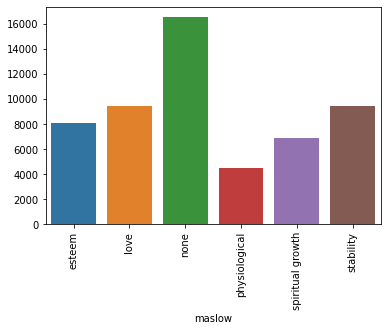

In [ ]:
import seaborn as sns 
c = df3.groupby('maslow')['maslow'].count()
sns.barplot(x = c.index, y = c.values)
plt.xticks(rotation = 90)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,8134
love,9483
none,16547
physiological,4487
spiritual growth,6927
stability,9488


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3

,sentence,maslow,reiss,maslowLabel
0,I began making fish curry for my boyfriend and I.,physiological,[food],3
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]",1
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]",3
2,I began making fish curry for my boyfriend and I.,physiological,[food],3
3,I began making fish curry for my boyfriend and I.,none,[none],2
...,...,...,...,...
47542,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47543,A crab was inside the shell pinching his leg.,spiritual growth,[curiosity],4
47544,A crab was inside the shell pinching his leg.,none,[none],2
47545,A crab was inside the shell pinching his leg.,stability,[tranquility],5


In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['physiological' 'love' 'none' 'spiritual growth' 'esteem' 'stability']
[3 1 2 4 0 5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['maslowLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=4487 (8.148%)
Class=1, n=9483 (17.221%)
Class=2, n=16547 (30.049%)
Class=4, n=6927 (12.579%)
Class=0, n=8134 (14.771%)
Class=5, n=9488 (17.230%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,i began making fish curry boyfriend i,physiological,[food],3
1,i began making fish curry boyfriend i,love,"[family, romance, food]",1
1,i began making fish curry boyfriend i,physiological,"[family, romance, food]",3
2,i began making fish curry boyfriend i,physiological,[food],3
3,i began making fish curry boyfriend i,none,[none],2
...,...,...,...,...
47542,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47543,a crab inside shell pinching leg,spiritual growth,[curiosity],4
47544,a crab inside shell pinching leg,none,[none],2
47545,a crab inside shell pinching leg,stability,[tranquility],5


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

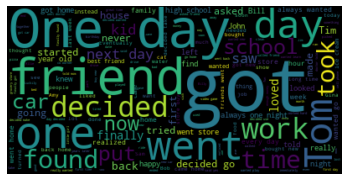

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 7254 samples and 295640 outcomes>
7254


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
21422,one day i decided i wanted become professional...,spiritual growth,[curiosity],4


### Model FFN with CNN

In [ ]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers import GlobalMaxPooling1D

In [ ]:
#input_array = np.random.randint(1000, size=(32, 10))
#print(input_array.ndim)
#print(input_array.shape)
#print(input_array.size)
#k = input_array.flatten()
#print(len(k))
#print(input_array)

In [ ]:
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 62, 100)           725400    
                                                                 
 conv1d (Conv1D)             (None, 60, 250)           75250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 activation (Activation)     (None, 250)               0         
                                                        

In [ ]:
'''
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
'''

"\nMETRICS = [\n      keras.metrics.TruePositives(name='tp'),\n      keras.metrics.FalsePositives(name='fp'),\n      keras.metrics.TrueNegatives(name='tn'),\n      keras.metrics.FalseNegatives(name='fn'), \n      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),\n      keras.metrics.Precision(name='precision'),\n      keras.metrics.Recall(name='recall'),\n      keras.metrics.AUC(name='auc'),\n      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve\n]\n"

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= 'accuracy')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(44052,)
(11014,)


In [ ]:
tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 7254, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
print(x_train.ndim)
print(x_train.shape)
print(x_test.shape)

2
(44052, 62)
(11014, 62)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
model.fit(x_train, y_train,verbose=1, validation_data = (x_test, y_test), batch_size = 32, epochs = epochs)

Epoch 1/10
1377/1377 [==============================] - 57s 40ms/step - loss: 1.6314 - accuracy: 0.3348 - val_loss: 1.7998 - val_accuracy: 0.2584
Epoch 2/10
1377/1377 [==============================] - 64s 47ms/step - loss: 1.4744 - accuracy: 0.4066 - val_loss: 1.8779 - val_accuracy: 0.2330
Epoch 3/10
1377/1377 [==============================] - 55s 40ms/step - loss: 1.3705 - accuracy: 0.4376 - val_loss: 1.8776 - val_accuracy: 0.2261
Epoch 4/10
1377/1377 [==============================] - 50s 37ms/step - loss: 1.2897 - accuracy: 0.4540 - val_loss: 1.9926 - val_accuracy: 0.2272
Epoch 5/10
1377/1377 [==============================] - 53s 39ms/step - loss: 1.2199 - accuracy: 0.4635 - val_loss: 2.1604 - val_accuracy: 0.2400
Epoch 6/10
1377/1377 [==============================] - 49s 35ms/step - loss: 1.1627 - accuracy: 0.4685 - val_loss: 2.2345 - val_accuracy: 0.2468
Epoch 7/10
1377/1377 [==============================] - 51s 37ms/step - loss: 1.1166 - accuracy: 0.4737 - val_loss: 2.3498 -

In [ ]:
model.evaluate(x_test, y_test)

345/345 [==============================] - 3s 9ms/step - loss: 2.6645 - accuracy: 0.2214


[2.6644864082336426, 0.2213546335697174]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([0.03046741, 0.5054372 , 0.23377813, 0.12541716, 0.01784164,
       0.08705846], dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(11014,)

In [ ]:
review_predictions

array([0, 2, 1, ..., 2, 0, 5])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    1521
1    2360
2    4147
3     931
4     600
5    1455
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[ 214  303  452  104  205  243]
 [ 334  408  702  200  299  417]
 [ 591  722 1242  387  502  703]
 [ 154  130  269   66  132  180]
 [ 106   99  185   48   67   95]
 [ 228  235  460   92  180  260]]


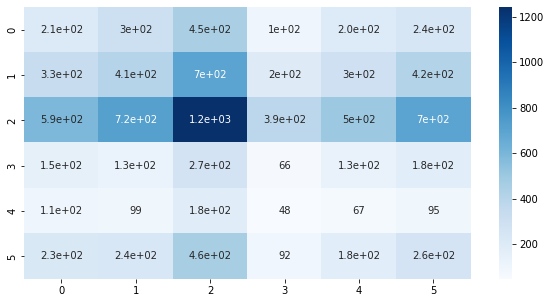

In [ ]:
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['esteem', 'love', 'none', 'physiological', 'spiritual growth',
       'stability'], dtype=object)

In [ ]:
#y_test_text

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
#integer_label[0:20]

In [ ]:
#text_label[0:20]

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesMaslow = list(df4['maslow'].unique())
uniqueClassesMaslowLabel = list(df4['maslowLabel'].unique())

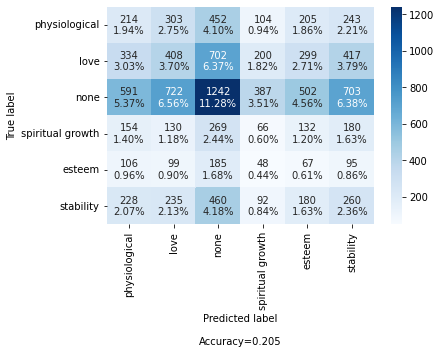

In [ ]:
make_confusion_matrix(r1, group_names=uniqueClassesMaslowLabel, categories=uniqueClassesMaslow, cmap='Blues')

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
#x_test_text[0:5]

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

two boy knocked book arm hallway
we became close friend made time much easier
his instructor shook head disappointingly
every month mailed gift
he famous antic attracted new customer
he made varsity squad
her science teacher encouraged compete science fair
the band contacted two month wedding
within week everyone knew
my wife daughter went shopping queen


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(integer_label, review_predictions)

print('Labels::{}'.format(uniqueClassesMaslow))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Labels::['physiological', 'love', 'none', 'spiritual growth', 'esteem', 'stability']
precision: [0.14069691 0.17288136 0.29949361 0.07089151 0.11166667 0.17869416]
recall: [0.13153042 0.21507644 0.37522659 0.0735786  0.04837545 0.1369863 ]
fscore: [0.13595934 0.19168428 0.33310983 0.07221007 0.0675063  0.155085  ]
support: [1627 1897 3310  897 1385 1898]


In [ ]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(integer_label, review_predictions)
print(cohen_score)

-0.0025701661192405467


# Final Code

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
#!pip install official

     |████████████████████████████████| 4.9 MB 11.6 MB/s 
     |████████████████████████████████| 1.8 MB 13.2 MB/s 
     |████████████████████████████████| 238 kB 64.8 MB/s 
     |████████████████████████████████| 352 kB 57.1 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 48.3 MB 113 kB/s 
     |████████████████████████████████| 1.2 MB 67.7 MB/s 
     |████████████████████████████████| 92 kB 11.5 MB/s 
     |████████████████████████████████| 99 kB 11.0 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.2 MB/s 


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras import regularizers
from keras.layers import Dense, Embedding, LSTM,Dropout,Activation, Conv1D, MaxPooling1D, SimpleRNN, GRU
import tensorflow as tf
import keras
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

tf.get_logger().setLevel('ERROR')

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('maslow')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]
1,I began making fish curry for my boyfriend and I.,love,"[family, romance, food]"
1,I began making fish curry for my boyfriend and I.,physiological,"[family, romance, food]"
2,I began making fish curry for my boyfriend and I.,physiological,[food]
3,I began making fish curry for my boyfriend and I.,none,[none]


In [ ]:
df3 = df3.drop_duplicates(subset = ['sentence']).reset_index(drop = True)

### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(12409, 3)

In [ ]:
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,1415
love,1298
none,5638
physiological,866
spiritual growth,1527
stability,1665


In [ ]:
df3.head(1)

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,physiological,[food]


In [ ]:
undersampling_count = df3[['sentence','maslow']].groupby('maslow').count().min()[0]
print(undersampling_count)   # Therefore we dont sample Phsycological as it has the minimum number of sample i.e dataframe[0]

866


In [ ]:
print(df3['maslow'].unique())
dontSeeIndex = 0

['physiological' 'spiritual growth' 'esteem' 'none' 'love' 'stability']


In [ ]:
from sklearn.utils import shuffle
lis = list(df3['maslow'].unique())
print(type(lis))
print(lis)
dataframes = []
for i in range(len(lis)):
    dataframe = 't' + str(i)
    dataframe = df3[df3['maslow'] == lis[i]]
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop(columns = 'index')
    if i!=dontSeeIndex:
        dataframe = shuffle(dataframe)
        dataframe = dataframe.iloc[:4487][:]
    dataframes.append(dataframe)
dataframes[0].head(1)
dataframes[5].head(1)

<class 'list'>
['physiological', 'spiritual growth', 'esteem', 'none', 'love', 'stability']


,sentence,maslow,reiss
650,Jimmy wanted to lose weight.,stability,[health]


In [ ]:
df3 = pd.concat(dataframes)
df3 = shuffle(df3)
df3 = df3.reset_index()
df3 = df3.drop(columns = 'index')
df3[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,1415
love,1298
none,4487
physiological,866
spiritual growth,1527
stability,1665


In [ ]:
lb = LabelEncoder() 
df3['maslowLabel'] = lb.fit_transform(df3['maslow'])

In [ ]:
df3.head()

,sentence,maslow,reiss,maslowLabel
0,Our seven year old son was in his class Xmas s...,none,[none],2
1,They showed him a website that helped him unde...,spiritual growth,[indep],4
2,The front of the magazine promised eight.,none,[none],2
3,Wade's wife told him to take the trash out.,stability,[order],5
4,She had to make an emergency trip to the schoo...,none,[none],2


In [ ]:
print(df3['maslow'].unique())
print(df3['maslowLabel'].unique())

['none' 'spiritual growth' 'stability' 'physiological' 'love' 'esteem']
[2 4 5 3 1 0]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['maslowLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=4487 (39.856%)
Class=4, n=1527 (13.564%)
Class=5, n=1665 (14.789%)
Class=3, n=866 (7.692%)
Class=1, n=1298 (11.530%)
Class=0, n=1415 (12.569%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,maslowLabel
0,our seven year old son class xmas show 1996,none,[none],2
1,they showed website helped understand,spiritual growth,[indep],4
2,the front magazine promised eight,none,[none],2
3,wade wife told take trash,stability,[order],5
4,she make emergency trip school sign another,none,[none],2
...,...,...,...,...
11253,he take tonka toy dump truck play hour,none,[none],2
11254,will decided smoothie time week,none,[none],2
11255,my friend,none,[none],2
11256,it flipped sideways like knife,none,[none],2


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

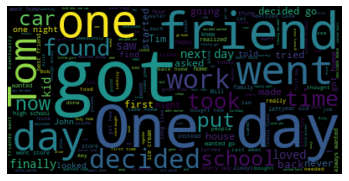

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(60),
                    columns=['Word', 'Frequency'])
print(rslt)

<FreqDist with 6966 samples and 59259 outcomes>
6966
       Word  Frequency
0        he       1457
1         i       1295
2       she       1205
3       the        771
4       day        523
5        nt        492
6       one        486
7      went        462
8       got        459
9   decided        455
10     they        395
11   friend        368
12   wanted        354
13      new        302
14       it        276
15    would        275
16      get        254
17    could        251
18     time        245
19     when        240
20     home        237
21       go        232
22     took        211
23    found        208
24     told        194
25     work        188
26      tom        187
27      his        183
28       my        183
29   bought        182
30      car        179
31   school        177
32      her        176
33     made        169
34      dog        169
35  finally        168
36        a        164
37      but        163
38    store        162
39  started        159
40  

In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
df4['sentence'].str.split(' ', expand=True).stack().value_counts()

he              1457
i               1295
she             1205
the              771
day              523
                ... 
certificate        1
appreciative       1
clicking           1
gesture            1
sideways           1
Length: 6966, dtype: int64

In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,maslowLabel
870,she worked hard academically maintain good gra...,spiritual growth,"[idealism, indep, honor, competition]",4


## Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df4['maslowLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9006,)
(2252,)


In [ ]:
'''
# CNN
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('sigmoid'))
'''

"\n# CNN\nbatch_size = 32\nfilters = 250\nkernel_size = 3\nhidden_dims = 250\nepochs = 10\n\nmodel = Sequential()\nmodel.add(Embedding(7254, 100, input_length=62))\nmodel.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))\nmodel.add(GlobalMaxPooling1D())\nmodel.add(Dense(hidden_dims))\nmodel.add(Dropout(0.2))\nmodel.add(Activation('relu'))\nmodel.add(Dense(6))\nmodel.add(Activation('sigmoid'))\n"

In [ ]:
'''
# WANT TO USE BERT: Here only change y to categorical rest to embeddings bert will take care
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
'''

'\n# WANT TO USE BERT: Here only change y to categorical rest to embeddings bert will take care\nbert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")\nbert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")\ntext_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=\'text\')\npreprocessed_text = bert_preprocess(text_input)\noutputs = bert_encoder(preprocessed_text)\nl = tf.keras.layers.Dropout(0.1, name="dropout")(outputs[\'pooled_output\'])\nl = tf.keras.layers.Dense(6, activation=\'softmax\', name="output")(l)\nmodel = tf.keras.Model(inputs=[text_input], outputs = [l])\n'

In [ ]:
tokenizer = Tokenizer(num_words = 6966, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 6966, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9006, 62)
(2252, 62)


In [ ]:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
from tensorflow.keras.layers import Bidirectional
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10
model = Sequential()
model.add(Embedding(input_dim = 6966, output_dim = 134, input_length=62))
model.add(Conv1D(filters = 250, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(300, activation = 'tanh', recurrent_dropout=0.2, dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(LSTM(300, activation = 'tanh', recurrent_dropout=0.2, dropout=0.2, return_sequences = True, kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.03)))
model.add(SimpleRNN(128))
model.add(Dropout(0.2))
model.add(Dense(units = 250, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 62, 134)           933444    
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 250)           100750    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 250)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 600)          1322400   
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 30, 600)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 300)          

In [ ]:
'''
model = Sequential()
model.add(Embedding(6799, 131, input_length=62))
model.add(Dropout(0.2))
model.add(LSTM(200, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))
model.summary()
'''

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.Accuracy(name="accuracy", dtype=None)
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,epochs=10,verbose=1,validation_data = (x_test, y_test))

Epoch 1/10
282/282 [==============================] - 152s 454ms/step - loss: 4.0788 - accuracy: 0.3970 - val_loss: 1.6337 - val_accuracy: 0.3988
Epoch 2/10
282/282 [==============================] - 127s 450ms/step - loss: 1.6386 - accuracy: 0.3985 - val_loss: 1.6282 - val_accuracy: 0.3988
Epoch 3/10
282/282 [==============================] - 126s 446ms/step - loss: 1.6370 - accuracy: 0.3985 - val_loss: 1.6360 - val_accuracy: 0.3988
Epoch 4/10
282/282 [==============================] - 129s 458ms/step - loss: 1.6336 - accuracy: 0.3985 - val_loss: 1.6321 - val_accuracy: 0.3988
Epoch 5/10
282/282 [==============================] - 127s 449ms/step - loss: 1.6333 - accuracy: 0.3985 - val_loss: 1.6372 - val_accuracy: 0.3988
Epoch 6/10
282/282 [==============================] - 126s 446ms/step - loss: 1.6341 - accuracy: 0.3985 - val_loss: 1.6295 - val_accuracy: 0.3988
Epoch 7/10
282/282 [==============================] - 127s 452ms/step - loss: 1.6322 - accuracy: 0.3985 - val_loss: 1.6305 -

In [ ]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 3s 41ms/step - loss: 1.6275 - accuracy: 0.3988


[1.6275075674057007, 0.39875665307044983]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


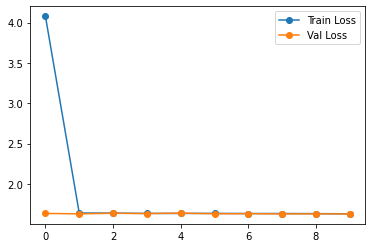

In [ ]:
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'], '-o', label = 'Val Loss')
plt.legend()

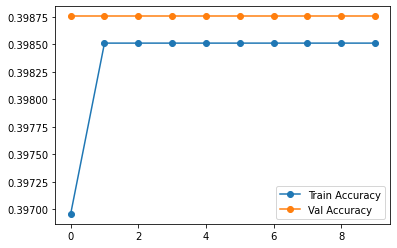

In [ ]:
plt.plot(history.history['accuracy'], '-o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'Val Accuracy')
plt.legend()

In [ ]:
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

In [ ]:
review_predictions_test = []
for prediction in y_pred_test:
    x = prediction
    review_predictions_test.append(np.argmax(x))

review_predictions_test = np.array(review_predictions_test)
review_predictions_test.reshape(1,-1)
review_predictions_test.shape

(2252,)

In [ ]:
review_predictions_train = []
for prediction in y_pred_train:
    x = prediction
    review_predictions_train.append(np.argmax(x))

review_predictions_train = np.array(review_predictions_train)
review_predictions_train.reshape(1,-1)
review_predictions_train.shape

(9006,)

In [ ]:
k = pd.DataFrame(review_predictions_train, columns = ['trainPredictedLabel'])
k.groupby('trainPredictedLabel')['trainPredictedLabel'].count()

trainPredictedLabel
2    9006
Name: trainPredictedLabel, dtype: int64

In [ ]:
actual = y_train_text.reset_index()
actual.head(3)

,index,maslowLabel
0,7713,2
1,636,2
2,9061,2


In [ ]:
k['actualLabel'] = actual['maslowLabel']
k.head(1)

,trainPredictedLabel,actualLabel
0,2,2


In [ ]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(k['actualLabel'], k['trainPredictedLabel'])

In [ ]:
k = pd.DataFrame(review_predictions_test, columns = ['testPredictedLabel'])
k.groupby('testPredictedLabel')['testPredictedLabel'].count()
actual = y_test_text.reset_index()
k['actualLabel'] = actual['maslowLabel']
test_acc = accuracy_score(k['actualLabel'], k['testPredictedLabel'])

In [ ]:
print('Training Accuracy:',train_acc)
print('Testing accuracy:',test_acc)

Training Accuracy: 0.3985121030424162
Testing accuracy: 0.3987566607460036


In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions_test, y_test_text)
print(r1)

[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [283 260 898 173 305 333]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


Resources: 

1. https://www.analyticssteps.com/blogs/what-stemming-and-lemmatization-nlp
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding


# With Uniform Reiss Classification

## T 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Embedding, LSTM,Dropout
import tensorflow as tf
import keras

from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('t.csv')

### Cleaning the Data

In [ ]:
df = df.iloc[:,5:]
df1 = df.drop(columns = ['action','motivation'])
#df1.head()

In [ ]:
def clean(string):
    res = string.strip('][').split(', ')
    lis = []
    for word in res:
        q = word.strip('][').split(', ')
        w = q[0].lstrip('\"')[:-1]
        if w == '' or w == 'na':
            lis.append('none')
        else:
            lis.append(w)
    string = lis
    for classes in lis:
        if classes not in uniqueClasses:
            uniqueClasses.append(classes)
    return string

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['maslow'][i] = clean(df1['maslow'][i]);
uniqueClassesMaslow = uniqueClasses

In [ ]:
uniqueClasses = []
for i in range(0,df1.shape[0]):
    df1['reiss'][i] = clean(df1['reiss'][i]);
uniqueClassesReiss = uniqueClasses

In [ ]:
df2 = df1
df3 = df2.explode('reiss')

In [ ]:
df3.head()

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,[physiological],food
1,I began making fish curry for my boyfriend and I.,"[love, physiological]",family
1,I began making fish curry for my boyfriend and I.,"[love, physiological]",romance
1,I began making fish curry for my boyfriend and I.,"[love, physiological]",food
2,I began making fish curry for my boyfriend and I.,[physiological],food


In [ ]:
df3 = df3.drop_duplicates(subset = ['sentence']).reset_index(drop = True)

### Cleaning the Data for NLP tasks

In [ ]:
df3.shape

(65503, 3)

In [ ]:
df3[['sentence','reiss']].groupby('reiss').count()

,sentence
reiss,
approval,3183
belonging,681
competition,2837
contact,4179
curiosity,3037
family,3248
food,2444
health,2129
honor,1645


In [ ]:
df3.head(1)

,sentence,maslow,reiss
0,I began making fish curry for my boyfriend and I.,[physiological],food


In [ ]:
list(df3['reiss'].unique())

['food',
 'family',
 'romance',
 'none',
 'indep',
 'competition',
 'approval',
 'health',
 'contact',
 'serenity',
 'rest',
 'order',
 'status',
 'idealism',
 'power',
 'curiosity',
 'honor',
 'belonging',
 'savings',
 'tranquility']

In [ ]:
undersampling_count = df3[['sentence','reiss']].groupby('reiss').count().min()[0]
print(undersampling_count)   # Therefore we dont sample Phsycological as it has the minimum number of sample i.e dataframe[0]

681


In [ ]:
dontSeeIndex = 10
lis = list(df3['reiss'].unique())
print(lis[10])

rest


In [ ]:
from sklearn.utils import shuffle
lis = list(df3['reiss'].unique())
print(type(lis))
print(lis)
dataframes = []
for i in range(len(lis)):
    dataframe = 't' + str(i)
    dataframe = df3[df3['reiss'] == lis[i]]
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop(columns = 'index')
    if i!=dontSeeIndex:
        dataframe = shuffle(dataframe)
        dataframe = dataframe.iloc[:681][:]
    dataframes.append(dataframe)
#dataframes[2].head(10)
dataframes[10].head(10)

<class 'list'>
['food', 'family', 'romance', 'none', 'indep', 'competition', 'approval', 'health', 'contact', 'serenity', 'rest', 'order', 'status', 'idealism', 'power', 'curiosity', 'honor', 'belonging', 'savings', 'tranquility']


,sentence,maslow,reiss
0,"That night, he turned the radio on and got int...",[physiological],rest
1,"That night, he turned the radio on and got int...","[stability, physiological]",rest
2,"That night, he turned the radio on and got int...",[physiological],rest
3,The radio played song after song all night lon...,[physiological],rest
4,The radio played song after song all night lon...,[physiological],rest
5,Gina returned to her desk from the bathroom.,[physiological],rest
6,"Tomorrow, I'll try putting a hot towel on it t...",[physiological],rest
7,I immediately fell asleep when I got home.,"[spiritual growth, physiological]",rest
8,I immediately fell asleep when I got home.,[physiological],rest
9,Matt walked on to the bus looked for a seat.,"[stability, physiological]",rest


In [ ]:
df3 = pd.concat(dataframes)
df3 = shuffle(df3)
df3 = df3.reset_index()
df3 = df3.drop(columns = 'index')
df3[['sentence','reiss']].groupby('reiss').count()

,sentence
reiss,
approval,681
belonging,681
competition,681
contact,681
curiosity,681
family,681
food,681
health,681
honor,681


In [ ]:
lb = LabelEncoder() 
df3['reissLabel'] = lb.fit_transform(df3['reiss'])

In [ ]:
df3

,sentence,maslow,reiss,reissLabel
0,Ivan took a few landscapes and some of himself.,[esteem],status,18
1,It was the most peaceful place I've ever visited.,[spiritual growth],serenity,17
2,Dave had entered a raffle at work this past we...,[esteem],competition,2
3,She liked to take a nice hot bath at the end o...,[physiological],rest,14
4,We moved across two states to be together.,[love],romance,15
...,...,...,...,...
13832,"He is terrified at first, but loves the adrena...","[spiritual growth, esteem]",status,18
13833,He offered to buy her a drink.,"[esteem, love]",contact,3
13834,He was supposed to board his plane soon.,[spiritual growth],serenity,17
13835,I laughed and told Bill that he really had it ...,[spiritual growth],idealism,9


In [ ]:
print(df3['reiss'].unique())
print(df3['reissLabel'].unique())

['status' 'serenity' 'competition' 'rest' 'romance' 'contact' 'idealism'
 'indep' 'health' 'none' 'food' 'power' 'tranquility' 'order' 'curiosity'
 'honor' 'savings' 'approval' 'belonging' 'family']
[18 17  2 14 15  3  9 10  7 11  6 13 19 12  4  8 16  0  1  5]


https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [ ]:
from collections import Counter
x = df3['sentence']
y = df3['reissLabel'] 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=18, n=681 (4.922%)
Class=17, n=681 (4.922%)
Class=2, n=681 (4.922%)
Class=14, n=898 (6.490%)
Class=15, n=681 (4.922%)
Class=3, n=681 (4.922%)
Class=9, n=681 (4.922%)
Class=10, n=681 (4.922%)
Class=7, n=681 (4.922%)
Class=11, n=681 (4.922%)
Class=6, n=681 (4.922%)
Class=13, n=681 (4.922%)
Class=19, n=681 (4.922%)
Class=12, n=681 (4.922%)
Class=4, n=681 (4.922%)
Class=8, n=681 (4.922%)
Class=16, n=681 (4.922%)
Class=0, n=681 (4.922%)
Class=1, n=681 (4.922%)
Class=5, n=681 (4.922%)


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def tokenization(string):
    words=nltk.word_tokenize(string)
    return ' '.join(words)

def removestopwords(string):
    for i in punctuation:
        string=string.replace(i,'')
    words=nltk.word_tokenize(string)
    k=[]
    eng_stop=stopwords.words('english')
    for each in words:
        if each not in eng_stop:
            k.append(each.lower())
    return ' '.join(k)

def lemmat(string):
    words=nltk.word_tokenize(string)
    ws=WordNetLemmatizer()
    l=[]
    for each in words:
        l.append(ws.lemmatize(each))
    return ' '.join(l)

def Refine(string):
    return lemmat(removestopwords(tokenization(string)))

In [ ]:
df4 = df3.copy()
df4['sentence']=df4['sentence'].apply(lambda x: Refine(x))
df4

,sentence,maslow,reiss,reissLabel
0,ivan took landscape,[esteem],status,18
1,it peaceful place i ever visited,[spiritual growth],serenity,17
2,dave entered raffle work past weekend,[esteem],competition,2
3,she liked take nice hot bath end day,[physiological],rest,14
4,we moved across two state together,[love],romance,15
...,...,...,...,...
13832,he terrified first love adrenaline rush,"[spiritual growth, esteem]",status,18
13833,he offered buy drink,"[esteem, love]",contact,3
13834,he supposed board plane soon,[spiritual growth],serenity,17
13835,i laughed told bill really coming,[spiritual growth],idealism,9


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

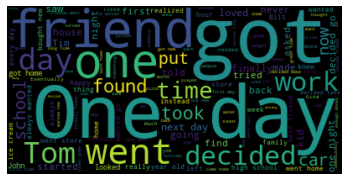

In [ ]:
common_words = ''
for i in df.sentence:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "
wordcloud = WordCloud().generate(common_words)   
plt.imshow(wordcloud, interpolation = 'bilinear')  # bilinear is used to display smooth images
plt.axis('off')
plt.show()

In [ ]:
k = pd.Series(np.concatenate([x.split() for x in df4.sentence])).value_counts()
a = df4['sentence'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)
print(len(word_dist))
rslt = pd.DataFrame(word_dist.most_common(30),
                    columns=['Word', 'Frequency'])
#print(rslt)

<FreqDist with 5804 samples and 74472 outcomes>
5804


In [ ]:
print(df4.sentence.map(lambda x: len(x)).max())

62


In [ ]:
lengths = df4["sentence"].str.len()
argmax = np.where(lengths == lengths.max())[0]
df4.iloc[argmax].head(1)

,sentence,maslow,reiss,reissLabel
1111,in stunner 10th seeded syracuse upset number 1...,[esteem],competition,2


### Model LSTM

In [ ]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

In [ ]:
model = Sequential()
model.add(Embedding(5780, 50, input_length=62))
model.add(Dropout(0.3))
model.add(LSTM(200, activation = 'tanh',kernel_regularizer=regularizers.l2(0.03)))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(20, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 62, 50)            289000    
                                                                 
 dropout_2 (Dropout)         (None, 62, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               200800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 20)                4020      
                                                                 
Total params: 534,020
Trainable params: 534,020
Non-tr

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.Accuracy(name = 'accuracy')
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= 'accuracy')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['reissLabel'],test_size = 0.2, random_state = 0, stratify = df4['reissLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(11069,)
(2768,)


In [ ]:
tokenizer = Tokenizer(num_words = 5780, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 5780, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
print(x_train.shape)
print(x_test.shape)

(11069, 62)
(2768, 62)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
history = model.fit(x_train, y_train,epochs=20,verbose=1,validation_split=0.1)

Epoch 1/20
312/312 [==============================] - 5s 10ms/step - loss: 3.2121 - accuracy: 0.0630 - val_loss: 2.9982 - val_accuracy: 0.0614
Epoch 2/20
312/312 [==============================] - 3s 8ms/step - loss: 2.9954 - accuracy: 0.0652 - val_loss: 2.9966 - val_accuracy: 0.0614
Epoch 3/20
312/312 [==============================] - 3s 9ms/step - loss: 2.9871 - accuracy: 0.0726 - val_loss: 2.9576 - val_accuracy: 0.0967
Epoch 4/20
312/312 [==============================] - 3s 9ms/step - loss: 2.8995 - accuracy: 0.1081 - val_loss: 2.9033 - val_accuracy: 0.0840
Epoch 5/20
312/312 [==============================] - 3s 10ms/step - loss: 2.8035 - accuracy: 0.1227 - val_loss: 2.8932 - val_accuracy: 0.0949
Epoch 6/20
312/312 [==============================] - 3s 8ms/step - loss: 2.7421 - accuracy: 0.1291 - val_loss: 2.8971 - val_accuracy: 0.0976
Epoch 7/20
312/312 [==============================] - 3s 8ms/step - loss: 2.7011 - accuracy: 0.1446 - val_loss: 2.9074 - val_accuracy: 0.1220
Epoc

In [ ]:
model.evaluate(x_test, y_test)

87/87 [==============================] - 1s 7ms/step - loss: 4.3535 - accuracy: 0.0542


[4.353510856628418, 0.054190751165151596]

### Evaluation and Analysis

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[2]

array([6.95191184e-03, 1.72844005e-03, 4.16448200e-03, 5.77787519e-04,
       7.28652701e-02, 6.01142831e-02, 1.79873634e-04, 6.75302057e-04,
       7.15091601e-02, 3.78202647e-01, 7.09536150e-02, 1.95248369e-02,
       1.22928254e-01, 1.23361565e-01, 3.69800728e-05, 3.85598923e-06,
       1.37765463e-02, 9.19624232e-03, 1.42586529e-02, 2.89903004e-02],
      dtype=float32)

In [ ]:
review_predictions = []
for prediction in y_pred:
    x = prediction
    review_predictions.append(np.argmax(x))

review_predictions = np.array(review_predictions)
review_predictions.reshape(1,-1)
review_predictions.shape

(2768,)

In [ ]:
review_predictions

array([ 0,  4,  9, ...,  5,  9, 10])

In [ ]:
k = pd.DataFrame(review_predictions, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0      92
1     164
2     103
3     185
4      61
5     189
6      70
7     191
8      60
9     239
10    158
11     77
12    146
13     67
14    126
15    226
16    201
17    146
18    188
19     79
Name: Label, dtype: int64

In [ ]:
type(y_test_text)

pandas.core.series.Series

In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions, y_test_text)
print(r1)

[[ 4  3  3  6  2  3  8  7  5  4  3  0  3  8  6  6  4  5  6  6]
 [ 7 10  8  8 11  8  9 10  7 11  6  7  9  8  8  9  7  6  5 10]
 [ 5  6  1  6  9  7  6  6  5  4  5  6  5  7  7  5  2  1  4  6]
 [ 7  4  7  9  6  7 11  9  8 10 12 11 12  6 15  4 15  9 10 13]
 [ 3  2  6  3  2  3  4  4  2  1  3  5  3  1  3  5  5  2  2  2]
 [ 6 11  6  9 13 12  7 11 10 15  6 10  6  8  9  8 10 11 11 10]
 [ 7  2  2  5  5  4  2  3  5  4  3  2  2  2  7  4  2  2  5  2]
 [ 6  9  6 13 15 11  7 13  5  9  7 14 14  6 13  8  8  9 10  8]
 [ 2  4  7  3  4  3  2  1  4  3  3  3  1  2  0  3  6  3  4  2]
 [15 12 19 10 11  6 10  6  6 12  9 10 14 20 16 10 10 18 14 11]
 [ 5 12  6  7  4  4  7 11 13  9 12  8  8  9 11 10  4  7  7  4]
 [ 3  3  4  8  1  4  5  5  4  4  7  5  1  1  8  1  2  2  8  1]
 [ 7 12 10  9  7  4  6  7  7  6  6 10  9  4  6  6 12  7  6  5]
 [ 2  5  1  4  4  2  1  4  4  6  5  4  4  5  4  3  1  2  3  3]
 [ 6  4  8  2  8  9  3  9  8  5  8  2  5 11  7  8  7  6  4  6]
 [14 11 11  9 11 13 19 10 10  8 12  8  7 11 21 13 10 11

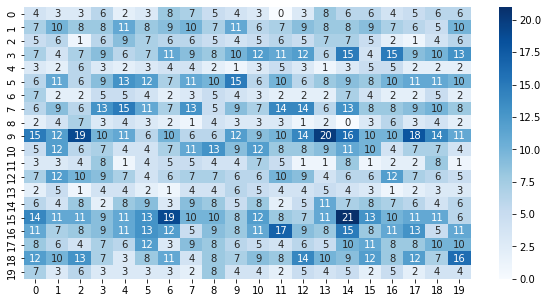

In [ ]:
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(r1, annot=True, cmap = 'Blues')

In [ ]:
lb.classes_

array(['approval', 'belonging', 'competition', 'contact', 'curiosity',
       'family', 'food', 'health', 'honor', 'idealism', 'indep', 'none',
       'order', 'power', 'rest', 'romance', 'savings', 'serenity',
       'status', 'tranquility'], dtype=object)

In [ ]:
#y_test_text

In [ ]:
text_label = pd.Series(lb.inverse_transform(y_test_text))
integer_label = pd.Series(y_test_text)

In [ ]:
integer_label = integer_label.reset_index(drop = True)
#integer_label[0:20]

In [ ]:
#text_label[0:20]

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = (20,20)

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesReiss = list(df4['reiss'].unique())
uniqueClassesReissLabel = list(df4['reissLabel'].unique())

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

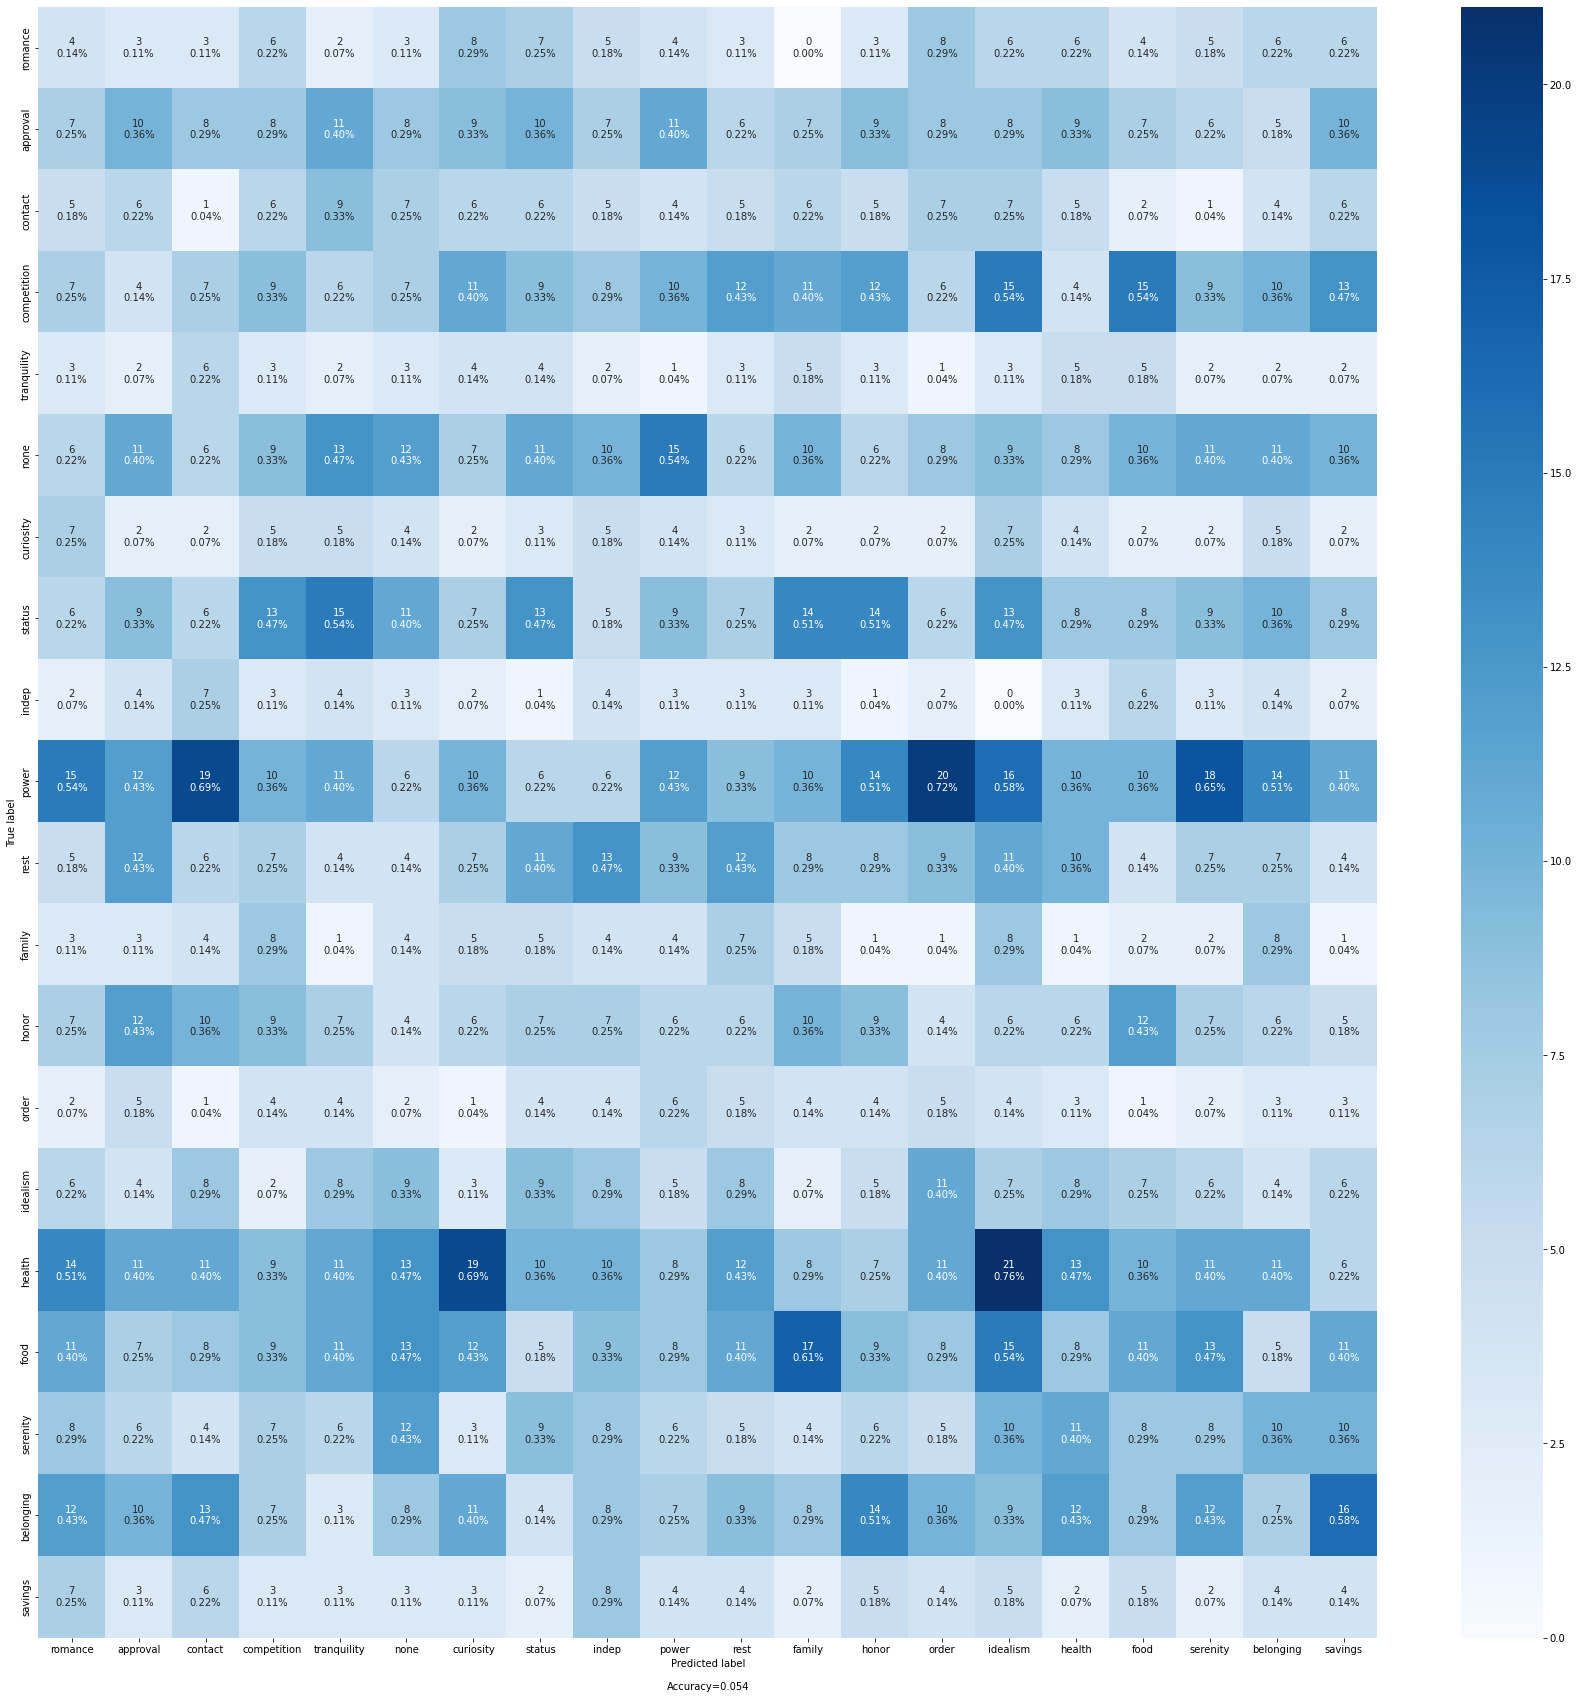

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)
make_confusion_matrix(r1, group_names=uniqueClassesReissLabel, categories=uniqueClassesReiss, cmap='Blues')
plt.show()

In [ ]:
x_test_text = x_test_text.reset_index(drop = True)
#x_test_text[0:5]

In [ ]:
count = 0
for i in range(0,len(review_predictions)):
    if review_predictions[i] != 0 and integer_label[i] == 0 and count != 10:
        print(x_test_text[i])
        count = count + 1

she tried different store expensive
instead racing stopped help injured runner
ray tried blame friend sense humor
she looked absolutely beautiful
she also interned local health department gain experience
her saving dwindling quickly
martin proceeded pick nice design name
his family nt think could live alone anymore
charlie stood decide jump kick walk away
a man went gas station fill gas tank


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(integer_label, review_predictions)

print('Labels::{}'.format(uniqueClassesMaslow))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Labels::['romance', 'approval', 'contact', 'competition', 'tranquility', 'none', 'curiosity', 'status', 'indep', 'power', 'rest', 'family', 'honor', 'order', 'idealism', 'health', 'food', 'serenity', 'belonging', 'savings']
precision: [0.04347826 0.06097561 0.00970874 0.04864865 0.03278689 0.06349206
 0.02857143 0.06806283 0.06666667 0.05020921 0.07594937 0.06493506
 0.06164384 0.07462687 0.05555556 0.05752212 0.05472637 0.05479452
 0.03723404 0.05063291]
recall: [0.02919708 0.07352941 0.00735294 0.06569343 0.01470588 0.08823529
 0.01470588 0.09558824 0.02941176 0.08823529 0.08823529 0.03676471
 0.06569343 0.03676471 0.03888889 0.09558824 0.08029197 0.05882353
 0.05147059 0.02941176]
fscore: [0.0349345  0.06666667 0.0083682  0.05590062 0.02030457 0.07384615
 0.01941748 0.0795107  0.04081633 0.064      0.08163265 0.04694836
 0.06360424 0.04926108 0.04575163 0.0718232  0.06508876 0.05673759
 0.04320988 0.0372093 ]
support: [137 136 136 137 136 136 136 136 136 136 136 136 137 136 180 136 

In [ ]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(integer_label, review_predictions)
print(cohen_score)

0.004476311159126167


## Reiss Another Model

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
#!pip install official

     |████████████████████████████████| 4.9 MB 13.4 MB/s 
     |████████████████████████████████| 1.8 MB 14.5 MB/s 
     |████████████████████████████████| 48.3 MB 95 kB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 238 kB 57.4 MB/s 
     |████████████████████████████████| 99 kB 9.8 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 352 kB 65.7 MB/s 
     |████████████████████████████████| 92 kB 11.2 MB/s 
     |████████████████████████████████| 1.2 MB 59.6 MB/s 
     |████████████████████████████████| 1.1 MB 69.9 MB/s 


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras import regularizers
from keras.layers import Dense, Embedding, LSTM,Dropout,Activation, Conv1D, MaxPooling1D, SimpleRNN, GRU
import tensorflow as tf
import keras
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from collections import Counter 
import wordcloud
from nltk.corpus import stopwords 
from textblob import Word 
import re
from string import punctuation
import nltk

tf.get_logger().setLevel('ERROR')

Rerun above cleaning again

### Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df4['sentence'],df4['reissLabel'],test_size = 0.2, random_state = 0, stratify = df4['reissLabel'])

In [ ]:
x_train_text = x_train 
x_test_text = x_test
y_train_text = y_train
y_test_text = y_test

In [ ]:
print(x_train.shape)
print(x_test.shape)

(11069,)
(2768,)


In [ ]:
'''
# CNN
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

model = Sequential()
model.add(Embedding(7254, 100, input_length=62))
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('sigmoid'))
'''

"\n# CNN\nbatch_size = 32\nfilters = 250\nkernel_size = 3\nhidden_dims = 250\nepochs = 10\n\nmodel = Sequential()\nmodel.add(Embedding(7254, 100, input_length=62))\nmodel.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu', strides = 1, input_shape = (44052, 62)))\nmodel.add(GlobalMaxPooling1D())\nmodel.add(Dense(hidden_dims))\nmodel.add(Dropout(0.2))\nmodel.add(Activation('relu'))\nmodel.add(Dense(6))\nmodel.add(Activation('sigmoid'))\n"

In [ ]:
'''
# WANT TO USE BERT: Here only change y to categorical rest to embeddings bert will take care
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
'''

'\n# WANT TO USE BERT: Here only change y to categorical rest to embeddings bert will take care\nbert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")\nbert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")\ntext_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=\'text\')\npreprocessed_text = bert_preprocess(text_input)\noutputs = bert_encoder(preprocessed_text)\nl = tf.keras.layers.Dropout(0.1, name="dropout")(outputs[\'pooled_output\'])\nl = tf.keras.layers.Dense(6, activation=\'softmax\', name="output")(l)\nmodel = tf.keras.Model(inputs=[text_input], outputs = [l])\n'

In [ ]:
tokenizer = Tokenizer(num_words = 5780, split = ' ')
tokenizer.fit_on_texts(x_train.values)
x = tokenizer.texts_to_sequences(x_train.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_train = x

tokenizer = Tokenizer(num_words = 5780, split = ' ')
tokenizer.fit_on_texts(x_test.values)
x = tokenizer.texts_to_sequences(x_test.values) # Numerical vectors got created
x = pad_sequences(x, maxlen=62)
x_test = x

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(11069, 62)
(2768, 62)


In [ ]:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
from tensorflow.keras.layers import Bidirectional
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10
model = Sequential()
model.add(Embedding(input_dim = 5780, output_dim = 131, input_length=62))
model.add(Conv1D(filters = 250, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(300, activation = 'tanh', recurrent_dropout=0.2, dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(LSTM(300, activation = 'tanh', recurrent_dropout=0.2, dropout=0.2, return_sequences = True, kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.03)))
model.add(SimpleRNN(128))
model.add(Dropout(0.2))
model.add(Dense(units = 250, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(20, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 62, 131)           757180    
                                                                 
 conv1d (Conv1D)             (None, 60, 250)           98500     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 250)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 30, 600)          1322400   
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 30, 600)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 300)          

In [ ]:
'''
model = Sequential()
model.add(Embedding(6799, 131, input_length=62))
model.add(Dropout(0.2))
model.add(LSTM(200, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'relu'))
model.add(Dense(6, activation='softmax'))
model.summary()
'''

"\nmodel = Sequential()\nmodel.add(Embedding(6799, 131, input_length=62))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(200, activation = 'tanh'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units = 200, activation = 'relu'))\nmodel.add(Dense(6, activation='softmax'))\nmodel.summary()\n"

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.Accuracy(name="accuracy", dtype=None)
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,epochs=10,verbose=1,validation_data = (x_test, y_test))

Epoch 1/10
346/346 [==============================] - 178s 471ms/step - loss: 4.9892 - accuracy: 0.0589 - val_loss: 2.9952 - val_accuracy: 0.0650
Epoch 2/10
346/346 [==============================] - 161s 467ms/step - loss: 2.9958 - accuracy: 0.0645 - val_loss: 2.9941 - val_accuracy: 0.0650
Epoch 3/10
346/346 [==============================] - 159s 460ms/step - loss: 2.9955 - accuracy: 0.0649 - val_loss: 2.9939 - val_accuracy: 0.0650
Epoch 4/10
346/346 [==============================] - 160s 463ms/step - loss: 2.9951 - accuracy: 0.0649 - val_loss: 2.9940 - val_accuracy: 0.0650
Epoch 5/10
346/346 [==============================] - 159s 458ms/step - loss: 2.9949 - accuracy: 0.0649 - val_loss: 2.9939 - val_accuracy: 0.0650
Epoch 6/10
346/346 [==============================] - 161s 464ms/step - loss: 2.9947 - accuracy: 0.0649 - val_loss: 2.9937 - val_accuracy: 0.0650
Epoch 7/10
346/346 [==============================] - 158s 457ms/step - loss: 2.9947 - accuracy: 0.0649 - val_loss: 2.9939 -

In [ ]:
model.evaluate(x_test, y_test)

87/87 [==============================] - 4s 44ms/step - loss: 2.9937 - accuracy: 0.0650


[2.9936509132385254, 0.06502889841794968]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


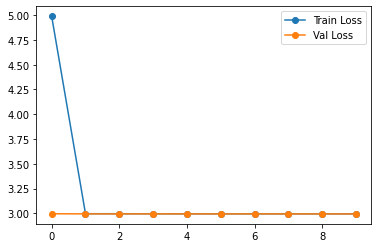

In [ ]:
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'], '-o', label = 'Val Loss')
plt.legend()

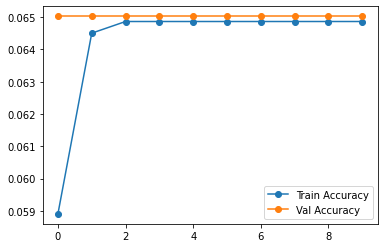

In [ ]:
plt.plot(history.history['accuracy'], '-o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'Val Accuracy')
plt.legend()

In [ ]:
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

In [ ]:
review_predictions_test = []
for prediction in y_pred_test:
    x = prediction
    review_predictions_test.append(np.argmax(x))

review_predictions_test = np.array(review_predictions_test)
review_predictions_test.reshape(1,-1)
review_predictions_test.shape

(2768,)

In [ ]:
review_predictions_train = []
for prediction in y_pred_train:
    x = prediction
    review_predictions_train.append(np.argmax(x))

review_predictions_train = np.array(review_predictions_train)
review_predictions_train.reshape(1,-1)
review_predictions_train.shape

(11069,)

In [ ]:
k = pd.DataFrame(review_predictions_train, columns = ['trainPredictedLabel'])
k.groupby('trainPredictedLabel')['trainPredictedLabel'].count()

trainPredictedLabel
14    11069
Name: trainPredictedLabel, dtype: int64

In [ ]:
actual = y_train_text.reset_index()
actual.head(3)

,index,reissLabel
0,13618,0
1,6400,9
2,4994,7


In [ ]:
k['actualLabel'] = actual['reissLabel']
k.head(1)

,trainPredictedLabel,actualLabel
0,14,0


In [ ]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(k['actualLabel'], k['trainPredictedLabel'])

In [ ]:
k = pd.DataFrame(review_predictions_test, columns = ['testPredictedLabel'])
k.groupby('testPredictedLabel')['testPredictedLabel'].count()
actual = y_test_text.reset_index()
k['actualLabel'] = actual['reissLabel']
test_acc = accuracy_score(k['actualLabel'], k['testPredictedLabel'])

In [ ]:
print('Training Accuracy:',train_acc)
print('Testing accuracy:',test_acc)

Training Accuracy: 0.06486584153943446
Testing accuracy: 0.06502890173410404


In [ ]:
import sklearn
r1 = sklearn.metrics.confusion_matrix(review_predictions_test, y_test_text)
print(r1)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Resources: 

1. https://www.analyticssteps.com/blogs/what-stemming-and-lemmatization-nlp
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
